## Notebook for OCEANS'19 Seattle conference paper
## _Tensor decomposition of multi-frequency echosounder time series_

**Authors**: Wu-Jung Lee, Valentina Staneva

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorly as tl

## Load and inspect data

### Calibrated Sv

In [2]:
Sv_raw_path = '/Volumes/wjlee_apl_2/ooi_zplsc_current/'
Sv_raw_fname = '20150817-20151017_Sv.h5'
f_Sv = h5py.File(os.path.join(Sv_raw_path,Sv_raw_fname),'r')

In [3]:
ping_time_Sv = np.array(f_Sv['ping_time'])

In [4]:
print('There are a total of %d pings per hour.' % (20*60/5))  # Number of pings per hour

There are a total of 240 pings per hour.


### Calibrated MVBS data

Here we first inspect the calibrated mean volume backscattering strength (MVBS, or $\overline{\textrm{S}_\textrm{V}}$) already pre-processed from the raw data.
The raw data were obtained from the Ocean Observatories Initiative (OOI) Raw Data 
Archive, from the Oregon Offshore Cabled Shallow Profiler Mooring (CE04OSPS).
All other info can be found in the paper.

In [5]:
# Set up paths
MVBS_raw_path = '/Users/wu-jung/code_git/ooi_sonar/sample_data/'
MVBS_raw_fname = '20150817-20151017_MVBS.h5'
fig_save_path = '/Users/wu-jung/code_git/ooi_sonar/tensor/figs_2019_paper/'

In [6]:
# Load raw MVBS data
f_raw = h5py.File(os.path.join(MVBS_raw_path,MVBS_raw_fname),'r')
MVBS_raw = np.array(f_raw['MVBS'])
depth_bin_size = np.array(f_raw['depth_bin_size'])
ping_time = np.array(f_raw['ping_time'])
# f_raw.close()

In [7]:
from matplotlib.dates import date2num, num2date

In [8]:
num2date(ping_time)

[datetime.datetime(2015, 8, 17, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 3, 20, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 6, 40, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 10, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 13, 20, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 16, 40, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 3, 20, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 6, 40, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 10, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 13, 20, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 16, 40, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 2, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 2, 3, 20, tzinfo=datetime.timezon

Let's first inspect the dimension of the data:

In [9]:
MVBS_raw.shape

(3, 40, 8928)

The first dimension is **frequency** (= 38, 120, and 200 kHz). The second dimension is **range** (or depth) from the echosounder location going upward towards the surface. The third dimension is **ping number**, which includes all pings in the selected date range collected by the echosounder. The MVBS data were obtained from the calibrated volume backscattering strength $\textrm{S}_\textrm{V}$ by averaging over every 40 pings and 5 m of data. The echosounder was set to transmit every 5 seconds for the first 20 minutes of each hour. Therefore by averaging every 40 pings, the MVBS data contains 6 tiles per hour, with a total of 144 tiles per day.

When plotting the data, note that we inverted the second dimension (depth), because the sonar was upward-looking from an underwater platform, and the echo time series was recorded from the source location. We only plot the first 37 depth bins because the last 3 bins contains very strong scattering from the sea surface that can dominate the decomposition. The surface scattering also include signatures from the tidal cycles that have a different periodicity than the daylight cycles on which our decomposition is structured.

In [10]:
def plot_3_echograms(echoes,cpd,dnum,dspace):
    """Plot a stack of 3 echograms.
    
    echoes   data to be plotted
    cpd      chunk per day
    dnum     number of days
    dspace   spacing between day ticks
    """
    fig,ax = plt.subplots(3,1,figsize=(16,5),sharex=True)
    plt.subplots_adjust(hspace=0.15)
    for f in range(3):
        im = ax[f].imshow(echoes[f],
                     aspect='auto', vmin=-80, vmax=-40, cmap='Spectral_r')
        ax[f].set_xticks(range(0,dnum*cpd,cpd*dspace))
        ax[f].set_xticklabels(range(0,dnum,dspace))
        ax[f].set_yticks(range(0,37,18))
        ax[f].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
        plt.setp(ax[f].get_xticklabels(), fontsize=13)
        plt.setp(ax[f].get_yticklabels(), fontsize=13)
        if ax[f].is_last_row():
            plt.xlabel('Day of observation',fontsize=16)
        if f==1:
            ax[f].set_ylabel('Depth (m)',fontsize=16)

    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.96, 0.12, 0.01, 0.76])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks(np.arange(-80, -39, 10))

    return fig

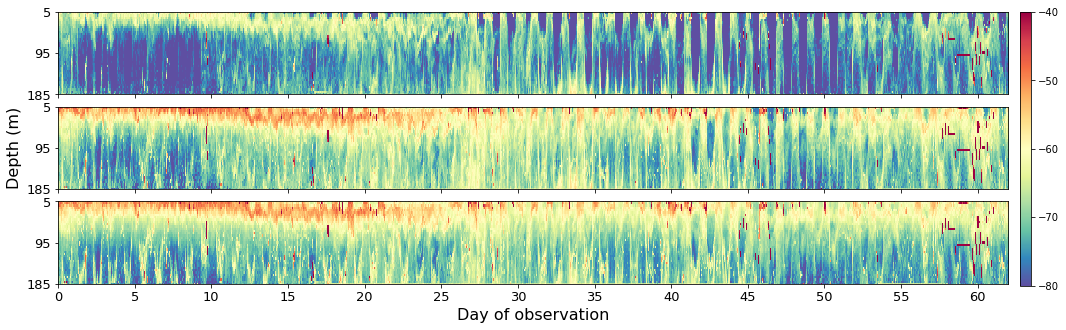

In [11]:
# Calibrated MVBS over selected data period
echoes_mvbs = []
for f in range(3):
    echoes_mvbs.append(MVBS_raw[f,37:0:-1,:])
    
fig = plot_3_echograms(echoes_mvbs,
                       cpd=144,dnum=65,dspace=5)

### MVBS cleaned using PCP

Seeing the many noisy echo patches in the original calibrated MVBS data, we employed Principal Component Pursuit (PCP) to separate the noisy component from the low-rank component before applying tensor decomposition. PCP takes some time to run, so here we will proceed by loading the low-rank component from PCP that has been calculated elsewhere.

In [12]:
# Load PCP-cleaned MVBS data
MVBS_pcp_path = MVBS_raw_path
MVBS_pcp_fname = '20150817-20151017_MVBS_PCPcleaned.h5'
f_pcp = h5py.File(os.path.join(MVBS_pcp_path,MVBS_pcp_fname),'r')

# Load only low-rank data
L = np.array(f_pcp['L'])
L_sep = np.array(f_pcp['L_sep'])
depth_bin_size = np.array(f_pcp['depth_bin_size'])
ping_per_day_mvbs = np.array(f_pcp['ping_per_day_mvbs'])
ping_time = np.array(f_pcp['ping_time'])
f_pcp.close()

The low-rank data is organized with dimension `frequency` x `day of observation` x `depth` x `chunk of pings within day`.

In [13]:
L_sep.shape

(3, 62, 37, 144)

Below we plot the low-rank data to compare with the original MVBS before PCP processing.

In [14]:
echoes_low_rank = []
for f in range(3):
    echoes_low_rank.append(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1)[::-1,:])

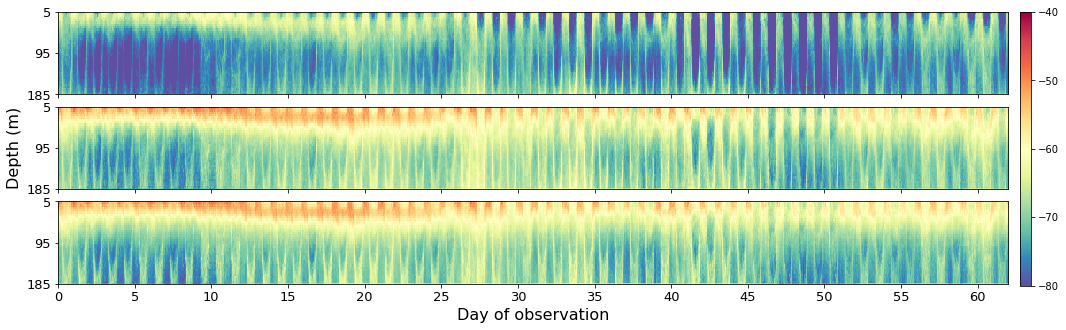

In [15]:
fig = plot_3_echograms(echoes_low_rank,
                       cpd=144,dnum=65,dspace=5)

### Data decimation

After some trial-and-error, we found out that tensor decomposition takes quite a bit of memory and that we can more efficiently run the decomposition by decimating the low-rank data by averaging 6 tiles of MVBS data, which effectively reduce the data to 1 observation per hour for each depth bin.

In [16]:
# Average across time of day columns
tod_num = 6
L_sep_reduce = np.empty(np.hstack((np.array(L_sep.shape[:3]),int(L_sep.shape[-1]/tod_num))))
for i in np.arange(int(L_sep.shape[-1]/tod_num)):
    L_sep_reduce[:,:,:,i] = np.mean(L_sep[:,:,:,i*tod_num+np.arange(tod_num)],axis=3)

In [17]:
L_sep_reduce.shape

(3, 62, 37, 24)

On the grand scale the decimated data look very similar to without averaging over the pings:

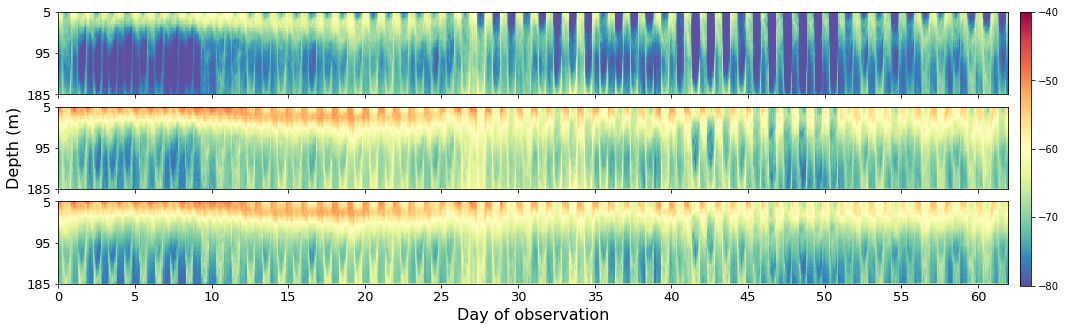

In [18]:
echoes_low_rank_reduce = []
for f in range(3):
    echoes_low_rank_reduce.append(tl.unfold(tl.tensor(L_sep_reduce[f,:,:,:].squeeze()),mode=1)[::-1,:])

fig = plot_3_echograms(echoes_low_rank_reduce,
                       cpd=24,dnum=65,dspace=5)

But obviously the effects of decimation are much more prominent when you look at only a smaller number of days:

First we look at the original MVBS data for the first 10 days:

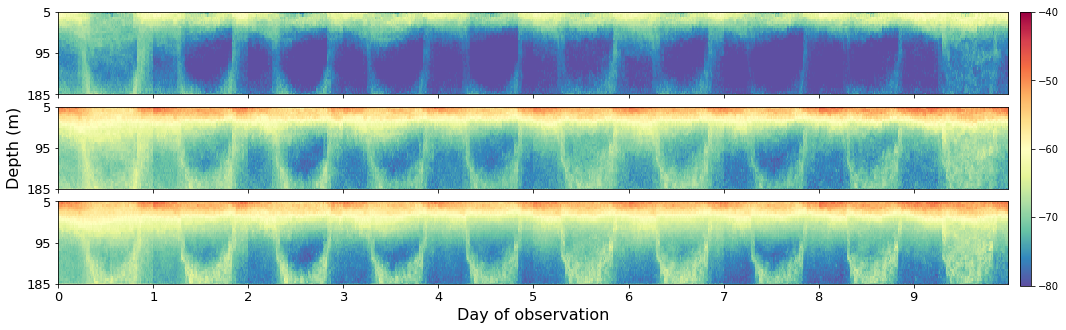

In [19]:
echoes_low_rank_10days = []
for f in range(3):
    echoes_low_rank_10days.append(tl.unfold(tl.tensor(L_sep[f,:10,:,:].squeeze()),mode=1)[::-1,:])

fig = plot_3_echograms(echoes_low_rank_10days,
                       cpd=144,dnum=10,dspace=1)

And when we compare it with the decimated data:

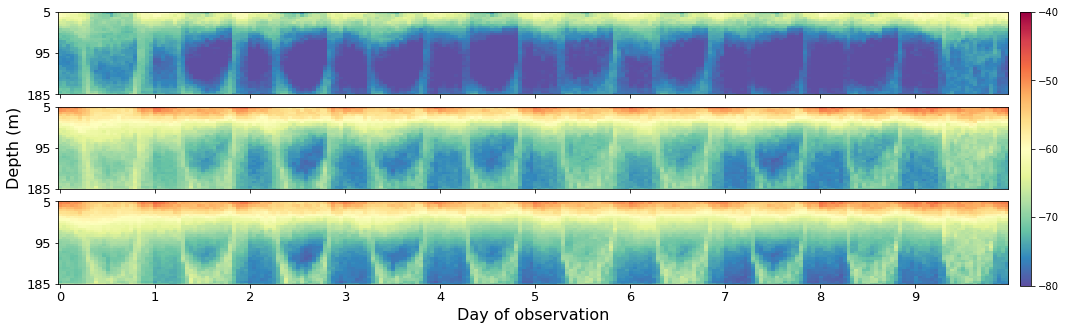

In [20]:
echoes_low_rank_reduce_10days = []
for f in range(3):
    echoes_low_rank_reduce_10days.append(tl.unfold(tl.tensor(L_sep_reduce[f,:10,:,:].squeeze()),mode=1)[::-1,:])

fig = plot_3_echograms(echoes_low_rank_reduce_10days,
                       cpd=24,dnum=10,dspace=1)

The basic features of the echograms are preserved in the decimated data, but the effects of quantization is also clearly visible.

## Restructuring data for tensor decomposition

Before performing tensor decomposition we need to reshape the low-rank data matrix into a tensor with all pixels within the daily echograms concatenated into a tall vector. 

This is because for decomposition, we actually don't want to decompose along each of the `frequency`, `day of observation`, `depth`, `chunk of pings within day` dimensions. Doing so will force decomposition along `depth` and `chunk of pings within day` separately, when in reality an organism group's movement in the water column (along `depth`) is coupled with the time of day (along `chunk of pings within day`).

Another way to think about this is that, for the Kruskal form of decomposition, it is not possible for a single component to capture the diel vertical migration (DVM), since the DVM pattern cannot be produced by an outer product of two vectors. It therefore makes more sense to go back to treate daily echogramss as images as it was done for NMF decomposition. The difference is that here we can arrange data from different frequencies along one specific dimension instead of concatenating them together.

### Reshaping the data matrix

We first inspect the dimension of the reduced low-rank data matrix:

In [21]:
L_sep_reduce.shape

(3, 62, 37, 24)

We then reshape this matrix to one that collapse all pixels within a daily echogram into a long vector:

In [22]:
L_sep_reduce_reshape = L_sep_reduce.reshape((3,62,37*24))

Let's plot the reshaped matrix out to check if it makes sense:

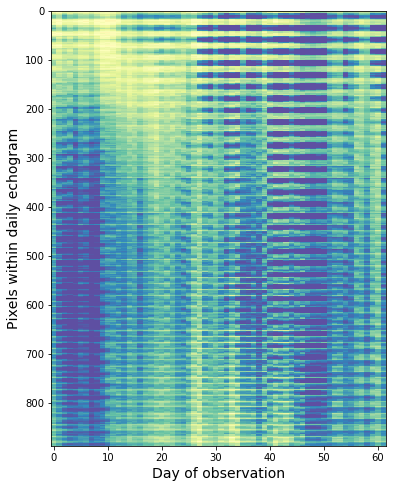

In [23]:
# Plot the first frequency of the reshaped reduced low-rank data matrix
fig = plt.figure(figsize=(6,8))
plt.imshow(tl.unfold(tl.tensor(L_sep_reduce_reshape[0,:,:]),mode=1)[::-1,:],
           vmin=-80, vmax=-40,
           aspect='auto',cmap='Spectral_r')
plt.xlabel('Day of observation',fontsize=14)
plt.ylabel('Pixels within daily echogram',fontsize=14)
plt.show()

This picture makes sense: The horizontal stripes within each column correspond with the number of depth bins for each ping. As organism vertical movements across consecutive days are typically smoothly-varying, the color changes smoothly along the horizontal dimension (`Day of observation`).

### Double check the reshaping results

The dimension of the tensor at each frequency is:

In [24]:
A = tl.unfold(tl.tensor(L_sep_reduce_reshape[0,:,:]),mode=1)
A.shape

(888, 62)

Just to make sure that we are getting the reshaping right, let's try to reconstruct the first day of observations at all 3 frequencies:

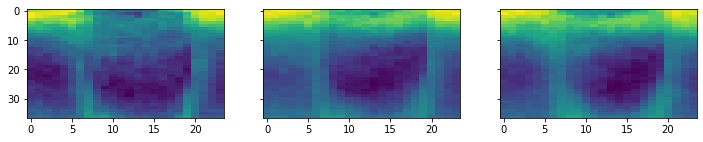

In [25]:
fig,ax = plt.subplots(1,3,figsize=(12,2),sharey=True)
for f in range(3):
    ax[f].imshow(A[:,f].reshape((37,24))[::-1,:],aspect='auto')
plt.show()

With the above confirmation now we define the sonar tensor:

In [26]:
sonar_tensor = tl.tensor(L_sep_reduce_reshape)

In [27]:
sonar_tensor.shape

(3, 62, 888)

## Kruskal tensor decomposition

Now let's try to decompose the reshaped and reduced low-rank matrix using the Kruskal form of tensor decomposition. The decomposition will be along three dimensions: `frequency`, `day of observation` and `pixels within daily echogram`.

In [28]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import parafac, non_negative_parafac
from tensorly.tenalg import kronecker, khatri_rao

### Rank=3

We set rank=3 because we are limited by the number of frequencies we have in the data set. Note that in order to run the non-negative version of Kruskal decomposition we need to make all observations positive by substracting the minimum value.

In [129]:
kruskal_rank = 3
factors_kruskal_3 = parafac(sonar_tensor-sonar_tensor.min(),  # regular kruskal
                            rank = kruskal_rank)
# factors_kruskal_nonneg_3 = non_negative_parafac(sonar_tensor-sonar_tensor.min(),  # non-negative kruskal
#                             rank = kruskal_rank,n_iter_max=100, tol=1e-7)
factors_kruskal_nonneg_3 = non_negative_parafac(sonar_tensor-sonar_tensor.min(),  # non-negative kruskal
                                                rank = kruskal_rank,
                                                n_iter_max=50000, 
                                                verbose=1, 
                                                tol=1e-10,init='svd')

reconstruction error=0.1797093914367159
reconstruction error=0.1500064754593727, variation=0.029702915977343203.
reconstruction error=0.13769040112023692, variation=0.012316074339135785.
reconstruction error=0.13000915261853768, variation=0.007681248501699239.
reconstruction error=0.12480003918041273, variation=0.005209113438124954.
reconstruction error=0.12105763275371527, variation=0.003742406426697459.
reconstruction error=0.11824834320052134, variation=0.0028092895531939277.
reconstruction error=0.11606480709934103, variation=0.002183536101180314.
reconstruction error=0.11431829537392832, variation=0.0017465117254127083.
reconstruction error=0.11288688523996783, variation=0.0014314101339604896.
reconstruction error=0.11168851087059238, variation=0.001198374369375449.
reconstruction error=0.11066603722326442, variation=0.001022473647327965.
reconstruction error=0.10977854814414385, variation=0.0008874890791205625.
reconstruction error=0.10899603338570857, variation=0.000782514758435

reconstruction error=0.07329713421383427, variation=0.00011687553650491234.
reconstruction error=0.07318338968149164, variation=0.00011374453234262727.
reconstruction error=0.07307266362456677, variation=0.00011072605692487303.
reconstruction error=0.0729648446167788, variation=0.00010781900778797371.
reconstruction error=0.0728598225976483, variation=0.00010502201913049902.
reconstruction error=0.07275748913584479, variation=0.00010233346180350822.
reconstruction error=0.07265773768649547, variation=9.975144934931679e-05.
reconstruction error=0.07256046383736937, variation=9.727384912609771e-05.
reconstruction error=0.07246556553988354, variation=9.489829748583756e-05.
reconstruction error=0.07237294332083752, variation=9.262221904601797e-05.
reconstruction error=0.07228250047208938, variation=9.044284874813735e-05.
reconstruction error=0.07219414321623463, variation=8.835725585475129e-05.
reconstruction error=0.07210778084653183, variation=8.636236970280264e-05.
reconstruction error=

reconstruction error=0.06709018174386389, variation=3.4981458154587086e-05.
reconstruction error=0.067055635338615, variation=3.4546405248886414e-05.
reconstruction error=0.06702152733430579, variation=3.410800430921068e-05.
reconstruction error=0.06698785993161047, variation=3.3667402695322646e-05.
reconstruction error=0.06695463423893976, variation=3.3225692670710294e-05.
reconstruction error=0.0669218503373155, variation=3.278390162425593e-05.
reconstruction error=0.06688950735267395, variation=3.2342984641553496e-05.
reconstruction error=0.06685760353432942, variation=3.190381834453082e-05.
reconstruction error=0.06682613633724274, variation=3.146719708667367e-05.
reconstruction error=0.06679510250725801, variation=3.1033829984733474e-05.
reconstruction error=0.06676449816664469, variation=3.060434061331885e-05.
reconstruction error=0.06673431889977216, variation=3.0179266872529253e-05.
reconstruction error=0.06670455983660482, variation=2.9759063167336675e-05.
reconstruction error

reconstruction error=0.06513128105852778, variation=5.655069564999837e-06.
reconstruction error=0.06512570068790045, variation=5.580370627325526e-06.
reconstruction error=0.06512019326030874, variation=5.507427591713854e-06.
reconstruction error=0.06511475705899787, variation=5.436201310868305e-06.
reconstruction error=0.06510939040569323, variation=5.366653304639257e-06.
reconstruction error=0.06510409165989257, variation=5.2987458006581445e-06.
reconstruction error=0.06509885921805666, variation=5.232441835908985e-06.
reconstruction error=0.06509369151300849, variation=5.167705048172988e-06.
reconstruction error=0.06508858701317508, variation=5.1044998334165426e-06.
reconstruction error=0.06508354422177794, variation=5.042791397139035e-06.
reconstruction error=0.06507856167635875, variation=4.982545419182638e-06.
reconstruction error=0.0650736379477796, variation=4.923728579159237e-06.
reconstruction error=0.06506877163977247, variation=4.866308007125952e-06.
reconstruction error=0.0

reconstruction error=0.06470115773336026, variation=2.720074095949321e-06.
reconstruction error=0.06469844120721875, variation=2.7165261415051933e-06.
reconstruction error=0.06469572815527593, variation=2.71305194282645e-06.
reconstruction error=0.06469301850703195, variation=2.709648243975904e-06.
reconstruction error=0.06469031219487333, variation=2.7063121586234917e-06.
reconstruction error=0.06468760915440838, variation=2.703040464943629e-06.
reconstruction error=0.0646849093240993, variation=2.6998303090802755e-06.
reconstruction error=0.06468221264533766, variation=2.696678761640592e-06.
reconstruction error=0.06467951906239643, variation=2.6935829412350065e-06.
reconstruction error=0.06467682852237058, variation=2.6905400258431245e-06.
reconstruction error=0.0646741409751292, variation=2.6875472413784296e-06.
reconstruction error=0.06467145637323177, variation=2.6846018974374664e-06.
reconstruction error=0.06466877467194741, variation=2.6817012843544097e-06.
reconstruction error

reconstruction error=0.06439389067081515, variation=2.329246653900996e-06.
reconstruction error=0.06439156561598089, variation=2.325054834259599e-06.
reconstruction error=0.06438924475964701, variation=2.3208563338789068e-06.
reconstruction error=0.06438692810822366, variation=2.316651423348026e-06.
reconstruction error=0.06438461566781643, variation=2.3124404072288884e-06.
reconstruction error=0.06438230744408358, variation=2.3082237328581057e-06.
reconstruction error=0.06438000344256288, variation=2.304001520694876e-06.
reconstruction error=0.06437770366833527, variation=2.299774227609852e-06.
reconstruction error=0.06437540812633859, variation=2.295541996683026e-06.
reconstruction error=0.06437311682114764, variation=2.291305190943449e-06.
reconstruction error=0.06437082975710762, variation=2.287064040026876e-06.
reconstruction error=0.06436854693837353, variation=2.2828187340867556e-06.
reconstruction error=0.0643662683687842, variation=2.278569589328483e-06.
reconstruction error=0

reconstruction error=0.06414737662146196, variation=1.814819214726593e-06.
reconstruction error=0.06414556618253031, variation=1.8104389316458969e-06.
reconstruction error=0.06414376012303355, variation=1.8060594967617138e-06.
reconstruction error=0.06414195844196954, variation=1.8016810640064662e-06.
reconstruction error=0.06414016113825023, variation=1.797303719311416e-06.
reconstruction error=0.06413836821074884, variation=1.7929275013955914e-06.
reconstruction error=0.06413657965811667, variation=1.7885526321648193e-06.
reconstruction error=0.06413479547898139, variation=1.784179135280728e-06.
reconstruction error=0.06413301567191297, variation=1.7798070684194034e-06.
reconstruction error=0.06413124023524058, variation=1.7754366723882198e-06.
reconstruction error=0.06412946916733013, variation=1.7710679104526728e-06.
reconstruction error=0.06412770246631419, variation=1.7667010159400087e-06.
reconstruction error=0.06412594013029786, variation=1.7623360163282475e-06.
reconstruction 

reconstruction error=0.06384951479784588, variation=1.011607839870865e-06.
reconstruction error=0.06384850650402105, variation=1.0082938248362483e-06.
reconstruction error=0.06384750152816021, variation=1.0049758608354775e-06.
reconstruction error=0.06384649987425758, variation=1.0016539026269644e-06.
reconstruction error=0.06384550154627291, variation=9.98327984669256e-07.
reconstruction error=0.06384450654812782, variation=9.949981450985135e-07.
reconstruction error=0.06384351488375499, variation=9.91664372826384e-07.
reconstruction error=0.06384252655698067, variation=9.88326774323256e-07.
reconstruction error=0.06384154157165924, variation=9.849853214310977e-07.
reconstruction error=0.06384055993156328, variation=9.816400959594684e-07.
reconstruction error=0.06383958164037405, variation=9.782911892242119e-07.
reconstruction error=0.06383860670174027, variation=9.749386337826182e-07.
reconstruction error=0.06383763511921743, variation=9.715825228379105e-07.
reconstruction error=0.06

reconstruction error=0.0637051187660094, variation=4.2567859064035485e-07.
reconstruction error=0.06370469483869344, variation=4.2392731595952693e-07.
reconstruction error=0.0637042726544591, variation=4.221842343360427e-07.
reconstruction error=0.06370385220510917, variation=4.2044934993323846e-07.
reconstruction error=0.06370343348249549, variation=4.1872261367925656e-07.
reconstruction error=0.06370301647856265, variation=4.1700393284271886e-07.
reconstruction error=0.0637026011852055, variation=4.1529335714773907e-07.
reconstruction error=0.06370218759444202, variation=4.1359076348446155e-07.
reconstruction error=0.0637017756983241, variation=4.118961179216951e-07.
reconstruction error=0.06370136548890325, variation=4.102094208480178e-07.
reconstruction error=0.0637009569582991, variation=4.085306041512471e-07.
reconstruction error=0.06370055009865938, variation=4.0685963971498484e-07.
reconstruction error=0.06370014490221325, variation=4.051964461321278e-07.
reconstruction error=0

reconstruction error=0.06364497340858832, variation=1.9552971819436493e-07.
reconstruction error=0.06364477846510429, variation=1.9494348403592543e-07.
reconstruction error=0.06364458410296966, variation=1.9436213462287188e-07.
reconstruction error=0.06364439031722555, variation=1.9378574411810234e-07.
reconstruction error=0.06364419710297567, variation=1.9321424987728264e-07.
reconstruction error=0.06364400445518864, variation=1.9264778702843266e-07.
reconstruction error=0.06364381236890146, variation=1.9208628718181409e-07.
reconstruction error=0.06364362083908834, variation=1.9152981312053896e-07.
reconstruction error=0.06364342986071955, variation=1.9097836878589902e-07.
reconstruction error=0.0636432394287406, variation=1.904319789497455e-07.
reconstruction error=0.06364304953807218, variation=1.8989066842556301e-07.
reconstruction error=0.06364286018361397, variation=1.893544582104445e-07.
reconstruction error=0.06364267136021806, variation=1.8882339590520214e-07.
reconstruction 

reconstruction error=0.0636047579594449, variation=2.1739118818975278e-07.
reconstruction error=0.06360454047558088, variation=2.174838640151e-07.
reconstruction error=0.06360432291967669, variation=2.1755590419447746e-07.
reconstruction error=0.06360410531260426, variation=2.1760707243079214e-07.
reconstruction error=0.06360388767539381, variation=2.176372104478741e-07.
reconstruction error=0.06360367002923568, variation=2.176461581238076e-07.
reconstruction error=0.06360345239550326, variation=2.1763373242444928e-07.
reconstruction error=0.0636032347956425, variation=2.1759986075509108e-07.
reconstruction error=0.06360301725119677, variation=2.1754444573529597e-07.
reconstruction error=0.0636027997838486, variation=2.1746734817085223e-07.
reconstruction error=0.06360258241529992, variation=2.173685486744903e-07.
reconstruction error=0.06360236516729288, variation=2.1724800704225888e-07.
reconstruction error=0.06360214806162136, variation=2.1710567152388727e-07.
reconstruction error=0

reconstruction error=0.06356956537578691, variation=1.0705870358285186e-07.
reconstruction error=0.0635694585568136, variation=1.0681897330555579e-07.
reconstruction error=0.06356935197670727, variation=1.0658010633768367e-07.
reconstruction error=0.06356924563469596, variation=1.0634201130788057e-07.
reconstruction error=0.06356913952992395, variation=1.0610477201022928e-07.
reconstruction error=0.06356903366159072, variation=1.058683332250121e-07.
reconstruction error=0.063568928028911, variation=1.0563267972829582e-07.
reconstruction error=0.06356882263111091, variation=1.0539780008478328e-07.
reconstruction error=0.063568717467428, variation=1.0516368291468847e-07.
reconstruction error=0.06356861253706554, variation=1.0493036245451393e-07.
reconstruction error=0.063568507839322, variation=1.0469774354426864e-07.
reconstruction error=0.063568403373433, variation=1.0446588899482023e-07.
reconstruction error=0.06356829913867605, variation=1.0423475695076068e-07.
reconstruction error=0

reconstruction error=0.0635586923600584, variation=8.337386409040803e-08.
reconstruction error=0.06355860916516963, variation=8.319488876973313e-08.
reconstruction error=0.06355852614883598, variation=8.301633365459526e-08.
reconstruction error=0.06355844331072673, variation=8.283810924714086e-08.
reconstruction error=0.06355836065038548, variation=8.266034125237187e-08.
reconstruction error=0.06355827816745677, variation=8.248292870938201e-08.
reconstruction error=0.06355819586154514, variation=8.230591162783352e-08.
reconstruction error=0.06355811373223795, variation=8.21293071884277e-08.
reconstruction error=0.06355803177914167, variation=8.195309628145075e-08.
reconstruction error=0.06355795000192555, variation=8.177721612379063e-08.
reconstruction error=0.06355786840012173, variation=8.160180381411308e-08.
reconstruction error=0.06355778697340334, variation=8.142671839572735e-08.
reconstruction error=0.06355770572135579, variation=8.12520475484968e-08.
reconstruction error=0.06355

reconstruction error=0.0635502043127462, variation=6.516696733627203e-08.
reconstruction error=0.0635501392848265, variation=6.502791970175448e-08.
reconstruction error=0.06355007439566916, variation=6.48891573390431e-08.
reconstruction error=0.06355000964498315, variation=6.475068600741984e-08.
reconstruction error=0.06354994503242985, variation=6.461255330769688e-08.
reconstruction error=0.06354988055772964, variation=6.447470020376489e-08.
reconstruction error=0.06354981622059723, variation=6.433713241327244e-08.
reconstruction error=0.06354975202069206, variation=6.4199905169815e-08.
reconstruction error=0.06354968795775741, variation=6.406293465155422e-08.
reconstruction error=0.06354962403146412, variation=6.392629328666466e-08.
reconstruction error=0.06354956024151548, variation=6.378994864275622e-08.
reconstruction error=0.06354949658763377, variation=6.365388170725961e-08.
reconstruction error=0.06354943306949366, variation=6.351814010874257e-08.
reconstruction error=0.0635493

reconstruction error=0.06354326117926135, variation=5.0372480575600065e-08.
reconstruction error=0.06354321091337413, variation=5.026588721646075e-08.
reconstruction error=0.06354316075384811, variation=5.0159526018833667e-08.
reconstruction error=0.06354311070045304, variation=5.0053395067584106e-08.
reconstruction error=0.06354306075296817, variation=4.99474848703052e-08.
reconstruction error=0.06354301091113466, variation=4.9841833507646705e-08.
reconstruction error=0.06354296117472988, variation=4.9736404786338007e-08.
reconstruction error=0.06354291154351784, variation=4.963121204293319e-08.
reconstruction error=0.0635428620172778, variation=4.952624003962125e-08.
reconstruction error=0.06354281259576616, variation=4.94215116331187e-08.
reconstruction error=0.06354276327874885, variation=4.931701731714089e-08.
reconstruction error=0.0635427140660013, variation=4.921274754376981e-08.
reconstruction error=0.06354266495731231, variation=4.9108688990329163e-08.
reconstruction error=0.

reconstruction error=0.0635381627600267, variation=3.9619886441077945e-08.
reconstruction error=0.06353812322295758, variation=3.953706911863364e-08.
reconstruction error=0.06353808376852116, variation=3.945443642627833e-08.
reconstruction error=0.0635380443965099, variation=3.9372011262361895e-08.
reconstruction error=0.06353800510674677, variation=3.928976312350674e-08.
reconstruction error=0.06353796589908332, variation=3.920766344922555e-08.
reconstruction error=0.06353792677327395, variation=3.9125809370155196e-08.
reconstruction error=0.06353788772919876, variation=3.90440751951715e-08.
reconstruction error=0.0635378487666388, variation=3.8962559956168263e-08.
reconstruction error=0.06353780988542278, variation=3.8881216024577725e-08.
reconstruction error=0.06353777108537743, variation=3.880004534329018e-08.
reconstruction error=0.06353773236632194, variation=3.871905548957777e-08.
reconstruction error=0.0635376937280621, variation=3.863825984162794e-08.
reconstruction error=0.06

reconstruction error=0.06353178755890194, variation=2.645744905105385e-08.
reconstruction error=0.06353176115492819, variation=2.640397375741621e-08.
reconstruction error=0.0635317348042526, variation=2.6350675585984362e-08.
reconstruction error=0.06353170850680283, variation=2.6297449773338144e-08.
reconstruction error=0.06353168226244937, variation=2.624435345432996e-08.
reconstruction error=0.0635316560710932, variation=2.6191356167215574e-08.
reconstruction error=0.06353162993255532, variation=2.613853788968612e-08.
reconstruction error=0.06353160384678049, variation=2.6085774831874353e-08.
reconstruction error=0.06353157781363351, variation=2.603314697147141e-08.
reconstruction error=0.06353155183297536, variation=2.5980658152624514e-08.
reconstruction error=0.063531525904707, variation=2.5928268365671414e-08.
reconstruction error=0.06353150002869705, variation=2.5876009945857703e-08.
reconstruction error=0.06353147420485408, variation=2.5823842966787858e-08.
reconstruction error=

reconstruction error=0.06352749861119027, variation=1.7970815807677454e-08.
reconstruction error=0.06352748067479838, variation=1.793639188563123e-08.
reconstruction error=0.06352746277276561, variation=1.790203277285407e-08.
reconstruction error=0.06352744490502149, variation=1.786774411760561e-08.
reconstruction error=0.06352742707146318, variation=1.7833558310642594e-08.
reconstruction error=0.06352740927202588, variation=1.7799437299070853e-08.
reconstruction error=0.06352739150663152, variation=1.7765394363933318e-08.
reconstruction error=0.06352737377521152, variation=1.773141999894534e-08.
reconstruction error=0.06352735607768206, variation=1.7697529455795724e-08.
reconstruction error=0.06352733841397648, variation=1.7663705581538736e-08.
reconstruction error=0.06352732078399764, variation=1.7629978837918614e-08.
reconstruction error=0.06352730318770744, variation=1.7596290202703813e-08.
reconstruction error=0.06352728562498586, variation=1.7562721582597973e-08.
reconstruction e

reconstruction error=0.06352573048947922, variation=1.4638053214000024e-08.
reconstruction error=0.06352571587837509, variation=1.4611104132145059e-08.
reconstruction error=0.06352570129417623, variation=1.4584198862466202e-08.
reconstruction error=0.06352568673681978, variation=1.4557356445288328e-08.
reconstruction error=0.06352567220624858, variation=1.4530571204596221e-08.
reconstruction error=0.06352565770239979, variation=1.450384878864952e-08.
reconstruction error=0.06352564322519526, variation=1.4477204532403753e-08.
reconstruction error=0.06352562877460456, variation=1.4450590696268861e-08.
reconstruction error=0.06352561435054954, variation=1.4424055019834903e-08.
reconstruction error=0.06352559995299976, variation=1.4397549777389607e-08.
reconstruction error=0.0635255855818447, variation=1.4371155057646412e-08.
reconstruction error=0.0635255712370558, variation=1.4344788912268314e-08.
reconstruction error=0.06352555691859878, variation=1.4318457017270525e-08.
reconstruction 

reconstruction error=0.0635242483794505, variation=1.1963136620218862e-08.
reconstruction error=0.06352423643734206, variation=1.1942108441020949e-08.
reconstruction error=0.06352422451617985, variation=1.1921162210160041e-08.
reconstruction error=0.06352421261594673, variation=1.1900233118367076e-08.
reconstruction error=0.06352420073655315, variation=1.1879393579938835e-08.
reconstruction error=0.0635241888780201, variation=1.1858533058295428e-08.
reconstruction error=0.06352417704025991, variation=1.1837760188759816e-08.
reconstruction error=0.06352416522323258, variation=1.1817027328886454e-08.
reconstruction error=0.06352415342689811, variation=1.1796334464797553e-08.
reconstruction error=0.06352414165119745, variation=1.1775700664573563e-08.
reconstruction error=0.06352412989611723, variation=1.1755080214781444e-08.
reconstruction error=0.06352411816156985, variation=1.1734547389341543e-08.
reconstruction error=0.06352410644754003, variation=1.1714029815590443e-08.
reconstruction

reconstruction error=0.06352205485332339, variation=8.283087646332454e-09.
reconstruction error=0.06352204658338771, variation=8.269935680704776e-09.
reconstruction error=0.06352203832652586, variation=8.256861847022456e-09.
reconstruction error=0.063522030082755, variation=8.243770860394406e-09.
reconstruction error=0.06352202185201607, variation=8.230738937631266e-09.
reconstruction error=0.0635220136342976, variation=8.217718464043067e-09.
reconstruction error=0.06352200542957487, variation=8.204722734550529e-09.
reconstruction error=0.06352199723781926, variation=8.191755607178663e-09.
reconstruction error=0.06352198905899079, variation=8.17882847559126e-09.
reconstruction error=0.06352198089306466, variation=8.165926129732881e-09.
reconstruction error=0.06352197274005614, variation=8.153008518307914e-09.
reconstruction error=0.0635219645998871, variation=8.140169038828304e-09.
reconstruction error=0.06352195647254419, variation=8.127342909780566e-09.
reconstruction error=0.0635219

reconstruction error=0.0635211766022433, variation=6.92277410396791e-09.
reconstruction error=0.06352116968989266, variation=6.912350636323339e-09.
reconstruction error=0.06352116278797507, variation=6.90191759300518e-09.
reconstruction error=0.06352115589645808, variation=6.891516982077128e-09.
reconstruction error=0.06352114901531122, variation=6.88114686064889e-09.
reconstruction error=0.06352114214453834, variation=6.8707728811956414e-09.
reconstruction error=0.06352113528408034, variation=6.860458007240666e-09.
reconstruction error=0.06352112843397531, variation=6.850105024880371e-09.
reconstruction error=0.06352112159416803, variation=6.83980727611555e-09.
reconstruction error=0.06352111476464134, variation=6.829526694174248e-09.
reconstruction error=0.06352110794539141, variation=6.819249928624593e-09.
reconstruction error=0.06352110113636493, variation=6.809026481535696e-09.
reconstruction error=0.063521094337579, variation=6.798785923134432e-09.
reconstruction error=0.06352108

reconstruction error=0.06351991710328111, variation=5.082331472339163e-09.
reconstruction error=0.06351991202814343, variation=5.07513768510659e-09.
reconstruction error=0.06351990696017669, variation=5.067966740712748e-09.
reconstruction error=0.06351990189938278, variation=5.060793908939765e-09.
reconstruction error=0.06351989684573502, variation=5.0536477641527355e-09.
reconstruction error=0.06351989179923534, variation=5.046499676475413e-09.
reconstruction error=0.06351988675987037, variation=5.039364966985538e-09.
reconstruction error=0.06351988172760203, variation=5.032268338145407e-09.
reconstruction error=0.06351987670244363, variation=5.0251584005067684e-09.
reconstruction error=0.06351987168440282, variation=5.018040816207048e-09.
reconstruction error=0.06351986667342052, variation=5.010982295772237e-09.
reconstruction error=0.06351986166950815, variation=5.0039123677958486e-09.
reconstruction error=0.06351985667266573, variation=4.996842425941672e-09.
reconstruction error=0.

reconstruction error=0.06351939075907616, variation=4.345345749889873e-09.
reconstruction error=0.0635193864197485, variation=4.339327661084802e-09.
reconstruction error=0.063519382086418, variation=4.333330499983745e-09.
reconstruction error=0.06351937775904842, variation=4.327369573786655e-09.
reconstruction error=0.06351937343766838, variation=4.321380045468892e-09.
reconstruction error=0.06351936912226452, variation=4.315403853705213e-09.
reconstruction error=0.06351936481280636, variation=4.3094581653191355e-09.
reconstruction error=0.06351936050930343, variation=4.303502929015046e-09.
reconstruction error=0.06351935621172523, variation=4.297578196088558e-09.
reconstruction error=0.06351935192009273, variation=4.291632507702481e-09.
reconstruction error=0.06351934763436211, variation=4.285730617614725e-09.
reconstruction error=0.06351934335454477, variation=4.2798173338631784e-09.
reconstruction error=0.06351933908063122, variation=4.2739135563962805e-09.
reconstruction error=0.06

reconstruction error=0.06351861079727203, variation=3.290335739980499e-09.
reconstruction error=0.0635186075112432, variation=3.286028824045495e-09.
reconstruction error=0.06351860422951938, variation=3.2817238232452084e-09.
reconstruction error=0.06351860095206435, variation=3.2774550295933125e-09.
reconstruction error=0.0635185976789048, variation=3.273159548955462e-09.
reconstruction error=0.06351859441003121, variation=3.268873588480048e-09.
reconstruction error=0.0635185911454226, variation=3.264608611219799e-09.
reconstruction error=0.06351858788507327, variation=3.2603493377303394e-09.
reconstruction error=0.06351858462897557, variation=3.256097697024174e-09.
reconstruction error=0.06351858137715431, variation=3.251821256711196e-09.
reconstruction error=0.06351857812955229, variation=3.2476020206395617e-09.
reconstruction error=0.0635185748861924, variation=3.2433598862180446e-09.
reconstruction error=0.06351857164704795, variation=3.2391444526602697e-09.
reconstruction error=0.

reconstruction error=0.06351827074146482, variation=2.854703098909006e-09.
reconstruction error=0.06351826789029877, variation=2.8511660532526406e-09.
reconstruction error=0.06351826504267356, variation=2.8476252050824158e-09.
reconstruction error=0.0635182621986235, variation=2.844050064898518e-09.
reconstruction error=0.06351825935807426, variation=2.8405492402683308e-09.
reconstruction error=0.06351825652104873, variation=2.8370255311660486e-09.
reconstruction error=0.06351825368754688, variation=2.833501849819342e-09.
reconstruction error=0.06351825085756492, variation=2.829981957108707e-09.
reconstruction error=0.06351824803109712, variation=2.8264677959244366e-09.
reconstruction error=0.06351824520811301, variation=2.8229841103621922e-09.
reconstruction error=0.0635182423886202, variation=2.819492819772229e-09.
reconstruction error=0.06351823957263202, variation=2.815988178750395e-09.
reconstruction error=0.06351823676010655, variation=2.812525462525528e-09.
reconstruction error=

reconstruction error=0.06351792517200944, variation=2.441211482961947e-09.
reconstruction error=0.06351792273359941, variation=2.4384100294483346e-09.
reconstruction error=0.06351792029794126, variation=2.435658147392772e-09.
reconstruction error=0.06351791786507885, variation=2.4328624115277364e-09.
reconstruction error=0.0635179154349569, variation=2.4301219508915395e-09.
reconstruction error=0.06351791300759255, variation=2.4273643511874e-09.
reconstruction error=0.06351791058298774, variation=2.4246048085929672e-09.
reconstruction error=0.06351790816113861, variation=2.421849124023545e-09.
reconstruction error=0.0635179057420109, variation=2.4191277175900083e-09.
reconstruction error=0.06351790332562365, variation=2.4163872430760236e-09.
reconstruction error=0.06351790091198259, variation=2.41364106479125e-09.
reconstruction error=0.06351789850104768, variation=2.410934910046514e-09.
reconstruction error=0.06351789609284751, variation=2.4082001670588937e-09.
reconstruction error=0.

reconstruction error=0.06351746056273253, variation=1.957657314033412e-09.
reconstruction error=0.06351745860689902, variation=1.9558335090374968e-09.
reconstruction error=0.06351745665285692, variation=1.954042094798325e-09.
reconstruction error=0.0635174547006577, variation=1.952199221721962e-09.
reconstruction error=0.06351745275025561, variation=1.9504020898342134e-09.
reconstruction error=0.06351745080166399, variation=1.9485916213923815e-09.
reconstruction error=0.0635174488548676, variation=1.9467963907615626e-09.
reconstruction error=0.0635174469098588, variation=1.945008792914038e-09.
reconstruction error=0.06351744496667573, variation=1.9431830727834054e-09.
reconstruction error=0.06351744302525357, variation=1.9414221619218353e-09.
reconstruction error=0.06351744108562857, variation=1.939625002278511e-09.
reconstruction error=0.063517439147774, variation=1.9378545712545048e-09.
reconstruction error=0.06351743721174515, variation=1.936028851123872e-09.
reconstruction error=0.

reconstruction error=0.06351706672983948, variation=1.6314058159938583e-09.
reconstruction error=0.06351706509961141, variation=1.6302280636537603e-09.
reconstruction error=0.063517063470563, variation=1.6290484100567326e-09.
reconstruction error=0.06351706184267904, variation=1.6278839665151423e-09.
reconstruction error=0.06351706021596139, variation=1.626717649472198e-09.
reconstruction error=0.06351705859042342, variation=1.6255379681195947e-09.
reconstruction error=0.06351705696606702, variation=1.6243563993878496e-09.
reconstruction error=0.06351705534286552, variation=1.623201503764271e-09.
reconstruction error=0.06351705372082843, variation=1.6220370879782564e-09.
reconstruction error=0.06351705209995387, variation=1.6208745595713836e-09.
reconstruction error=0.06351705048022277, variation=1.6197310992449587e-09.
reconstruction error=0.06351704886166944, variation=1.618553333027073e-09.
reconstruction error=0.0635170472442691, variation=1.617400338660424e-09.
reconstruction erro

reconstruction error=0.0635168819069628, variation=1.5070545089646004e-09.
reconstruction error=0.06351688040083257, variation=1.5061302205410243e-09.
reconstruction error=0.0635168788956114, variation=1.5052211699284612e-09.
reconstruction error=0.0635168773913336, variation=1.5042777995466494e-09.
reconstruction error=0.06351687588797818, variation=1.5033554262577908e-09.
reconstruction error=0.06351687438556994, variation=1.5024082394843319e-09.
reconstruction error=0.06351687288407074, variation=1.5014992027495566e-09.
reconstruction error=0.0635168713834863, variation=1.5005844344884167e-09.
reconstruction error=0.06351686988384142, variation=1.499644880498252e-09.
reconstruction error=0.06351686838509986, variation=1.4987415614120536e-09.
reconstruction error=0.06351686688727116, variation=1.4978286944078434e-09.
reconstruction error=0.06351686539036677, variation=1.4969043921064795e-09.
reconstruction error=0.06351686389437905, variation=1.49598772258841e-09.
reconstruction erro

reconstruction error=0.06351671858829934, variation=1.4139197312967866e-09.
reconstruction error=0.06351671717511523, variation=1.4131841113984578e-09.
reconstruction error=0.0635167157626553, variation=1.4124599267972826e-09.
reconstruction error=0.0635167143509291, variation=1.4117262081558835e-09.
reconstruction error=0.06351671293992708, variation=1.4110020096769205e-09.
reconstruction error=0.06351671152964163, variation=1.4102854578590396e-09.
reconstruction error=0.06351671012009179, variation=1.4095498379607108e-09.
reconstruction error=0.06351670871126806, variation=1.4088237243470303e-09.
reconstruction error=0.06351670730315899, variation=1.408109073786079e-09.
reconstruction error=0.06351670589575124, variation=1.4074077459014234e-09.
reconstruction error=0.06351670448909437, variation=1.4066568743142938e-09.
reconstruction error=0.06351670308313309, variation=1.4059612779560027e-09.
reconstruction error=0.06351670167788838, variation=1.405244712260334e-09.
reconstruction e

reconstruction error=0.06351644187967846, variation=1.2969465223999777e-09.
reconstruction error=0.06351644058314167, variation=1.2965367945927397e-09.
reconstruction error=0.06351643928702412, variation=1.2961175466230657e-09.
reconstruction error=0.06351643799133919, variation=1.2956849343437327e-09.
reconstruction error=0.06351643669605256, variation=1.2952866279558606e-09.
reconstruction error=0.06351643540119661, variation=1.2948559446890329e-09.
reconstruction error=0.06351643410674468, variation=1.2944519345303718e-09.
reconstruction error=0.0635164328127044, variation=1.2940402777106286e-09.
reconstruction error=0.06351643151908146, variation=1.293622944875672e-09.
reconstruction error=0.06351643022586635, variation=1.293215104447576e-09.
reconstruction error=0.06351642893304002, variation=1.2928263320999278e-09.
reconstruction error=0.06351642764062342, variation=1.29241660429269e-09.
reconstruction error=0.06351642634861464, variation=1.2920087777423817e-09.
reconstruction er

reconstruction error=0.06351619921867122, variation=1.2376391994584068e-09.
reconstruction error=0.06351619798123782, variation=1.237433391865217e-09.
reconstruction error=0.06351619674404836, variation=1.237189461988919e-09.
reconstruction error=0.0635161955070628, variation=1.2369855556526588e-09.
reconstruction error=0.06351619427026399, variation=1.2367988161399168e-09.
reconstruction error=0.06351619303371674, variation=1.2365472534803246e-09.
reconstruction error=0.06351619179736384, variation=1.2363528950620761e-09.
reconstruction error=0.0635161905612301, variation=1.2361337370370151e-09.
reconstruction error=0.06351618932530409, variation=1.2359260143091078e-09.
reconstruction error=0.06351618808956863, variation=1.2357354584047187e-09.
reconstruction error=0.06351618685407139, variation=1.2354972461769975e-09.
reconstruction error=0.06351618561877803, variation=1.2352933537185251e-09.
reconstruction error=0.06351618438368858, variation=1.2350894473822649e-09.
reconstruction e

reconstruction error=0.06351596613494216, variation=1.2055184489545567e-09.
reconstruction error=0.06351596492959334, variation=1.2053488207541818e-09.
reconstruction error=0.06351596372438169, variation=1.2052116526994894e-09.
reconstruction error=0.06351596251932441, variation=1.2050572761879152e-09.
reconstruction error=0.06351596131439861, variation=1.204925798026224e-09.
reconstruction error=0.0635159601096062, variation=1.2047924186076031e-09.
reconstruction error=0.06351595890498338, variation=1.2046228181628038e-09.
reconstruction error=0.06351595770049014, variation=1.2044932412580422e-09.
reconstruction error=0.06351595649614744, variation=1.204342695015903e-09.
reconstruction error=0.0635159552919305, variation=1.2042169345027887e-09.
reconstruction error=0.0635159540878889, variation=1.2040416025316247e-09.
reconstruction error=0.06351595288398067, variation=1.2039082369907916e-09.
reconstruction error=0.06351595168020202, variation=1.2037786462082423e-09.
reconstruction er

reconstruction error=0.06351583562073986, variation=1.1890332052288954e-09.
reconstruction error=0.06351583443189529, variation=1.1888445644592238e-09.
reconstruction error=0.06351583324319175, variation=1.1887035383795208e-09.
reconstruction error=0.06351583205465589, variation=1.1885358669472268e-09.
reconstruction error=0.06351583086630108, variation=1.1883548034496982e-09.
reconstruction error=0.06351582967810442, variation=1.1881966660576282e-09.
reconstruction error=0.06351582849006784, variation=1.1880365718974772e-09.
reconstruction error=0.06351582730222183, variation=1.1878460159930881e-09.
reconstruction error=0.06351582611452826, variation=1.1876935684940193e-09.
reconstruction error=0.06351582492701383, variation=1.187514434008996e-09.
reconstruction error=0.06351582373964992, variation=1.1873639016446447e-09.
reconstruction error=0.06351582255247278, variation=1.187177148254115e-09.
reconstruction error=0.06351582136546143, variation=1.187011350323175e-09.
reconstruction 

reconstruction error=0.06351559037758828, variation=1.1422846973863088e-09.
reconstruction error=0.06351558923560852, variation=1.1419797607548077e-09.
reconstruction error=0.06351558809392793, variation=1.1416805834052468e-09.
reconstruction error=0.06351558695254657, variation=1.1413813644223225e-09.
reconstruction error=0.06351558581145868, variation=1.1410878908435507e-09.
reconstruction error=0.06351558467066047, variation=1.1407982059008503e-09.
reconstruction error=0.06351558353015956, variation=1.1405009159304313e-09.
reconstruction error=0.06351558238996738, variation=1.140192176785071e-09.
reconstruction error=0.06351558125005724, variation=1.1399101385034527e-09.
reconstruction error=0.06351558011048443, variation=1.1395728111152081e-09.
reconstruction error=0.06351557897118222, variation=1.1393022081307436e-09.
reconstruction error=0.06351557783218305, variation=1.1389991727561721e-09.
reconstruction error=0.06351557669349449, variation=1.1386885601094576e-09.
reconstructio

reconstruction error=0.06351545786694676, variation=1.102223520788037e-09.
reconstruction error=0.06351545676511393, variation=1.1018328333056715e-09.
reconstruction error=0.06351545566365464, variation=1.1014592848912486e-09.
reconstruction error=0.06351545456259747, variation=1.1010571759895171e-09.
reconstruction error=0.06351545346192146, variation=1.1006760086695877e-09.
reconstruction error=0.06351545236161897, variation=1.1003024880107404e-09.
reconstruction error=0.06351545126173005, variation=1.0998889160562797e-09.
reconstruction error=0.06351545016221848, variation=1.0995115790057852e-09.
reconstruction error=0.06351544906310902, variation=1.099109456226266e-09.
reconstruction error=0.06351544796436548, variation=1.0987435405951373e-09.
reconstruction error=0.06351544686602978, variation=1.0983357001670413e-09.
reconstruction error=0.06351544576809239, variation=1.0979373937791692e-09.
reconstruction error=0.06351544467054186, variation=1.0975505226884508e-09.
reconstruction

reconstruction error=0.06351524809542088, variation=1.0131439853733326e-09.
reconstruction error=0.0635152470827724, variation=1.0126484789596546e-09.
reconstruction error=0.06351524607063277, variation=1.0121396221141055e-09.
reconstruction error=0.06351524505901154, variation=1.0116212312283324e-09.
reconstruction error=0.06351524404786486, variation=1.0111466802742441e-09.
reconstruction error=0.06351524303725563, variation=1.010609235185811e-09.
reconstruction error=0.06351524202716477, variation=1.0100908581778256e-09.
reconstruction error=0.06351524101753893, variation=1.0096258412639614e-09.
reconstruction error=0.0635152400084353, variation=1.0091036339865411e-09.
reconstruction error=0.063515238999831, variation=1.0086042973034282e-09.
reconstruction error=0.06351523799175651, variation=1.0080744849982892e-09.
reconstruction error=0.06351523698418135, variation=1.007575162192964e-09.
reconstruction error=0.06351523597710743, variation=1.0070739242529214e-09.
reconstruction err

reconstruction error=0.06351513218619725, variation=9.512329118832596e-10.
reconstruction error=0.06351513123548845, variation=9.507088033489097e-10.
reconstruction error=0.06351513028533423, variation=9.501542191925338e-10.
reconstruction error=0.06351512933570602, variation=9.496282094012543e-10.
reconstruction error=0.0635151283866229, variation=9.49083117651739e-10.
reconstruction error=0.06351512743809629, variation=9.485266183606456e-10.
reconstruction error=0.06351512649008233, variation=9.48013959001237e-10.
reconstruction error=0.06351512554262108, variation=9.474612483462153e-10.
reconstruction error=0.06351512459571251, variation=9.46908565446769e-10.
reconstruction error=0.06351512364932235, variation=9.463901606832081e-10.
reconstruction error=0.06351512270350011, variation=9.45822239972749e-10.
reconstruction error=0.06351512175819436, variation=9.453057503439055e-10.
reconstruction error=0.06351512081343559, variation=9.447587712152483e-10.
reconstruction error=0.0635151

reconstruction error=0.06351495711464465, variation=8.449264760068687e-10.
reconstruction error=0.063514956270269, variation=8.443756527309887e-10.
reconstruction error=0.06351495542642316, variation=8.438458404258498e-10.
reconstruction error=0.06351495458311095, variation=8.433122117290637e-10.
reconstruction error=0.06351495374034764, variation=8.427633035879012e-10.
reconstruction error=0.06351495289811797, variation=8.422296748911151e-10.
reconstruction error=0.06351495205641432, variation=8.417036512220477e-10.
reconstruction error=0.0635149512152824, variation=8.411319141199414e-10.
reconstruction error=0.06351495037465175, variation=8.406306484243231e-10.
reconstruction error=0.06351494953459857, variation=8.400531797958521e-10.
reconstruction error=0.0635149486950733, variation=8.395252687476429e-10.
reconstruction error=0.06351494785607598, variation=8.38997329943858e-10.
reconstruction error=0.0635149470176199, variation=8.384560823415654e-10.
reconstruction error=0.06351494

reconstruction error=0.06351486193648516, variation=7.830488479854125e-10.
reconstruction error=0.06351486115392611, variation=7.825590453425235e-10.
reconstruction error=0.06351486037188356, variation=7.820425557136801e-10.
reconstruction error=0.06351485959037846, variation=7.81505096747459e-10.
reconstruction error=0.0635148588093746, variation=7.810038588074164e-10.
reconstruction error=0.06351485802887581, variation=7.804987905979388e-10.
reconstruction error=0.06351485724889921, variation=7.799765971983064e-10.
reconstruction error=0.06351485646944291, variation=7.794563050556036e-10.
reconstruction error=0.06351485569049929, variation=7.789436179406195e-10.
reconstruction error=0.06351485491207216, variation=7.784271283117761e-10.
reconstruction error=0.06351485413413485, variation=7.779373117910993e-10.
reconstruction error=0.06351485335672737, variation=7.774074856081725e-10.
reconstruction error=0.06351485257982112, variation=7.769062476681299e-10.
reconstruction error=0.0635

reconstruction error=0.06351471186624465, variation=6.83749237784248e-10.
reconstruction error=0.06351471118298334, variation=6.832613086427131e-10.
reconstruction error=0.06351471050012034, variation=6.82863002254841e-10.
reconstruction error=0.06351470981774335, variation=6.823769882480235e-10.
reconstruction error=0.06351470913580089, variation=6.81942460833973e-10.
reconstruction error=0.06351470845431774, variation=6.814831476908978e-10.
reconstruction error=0.06351470777327867, variation=6.810390723588355e-10.
reconstruction error=0.06351470709269891, variation=6.805797592157603e-10.
reconstruction error=0.06351470641252512, variation=6.801737922890183e-10.
reconstruction error=0.06351470573285065, variation=6.796744694836931e-10.
reconstruction error=0.06351470505358021, variation=6.792704315694564e-10.
reconstruction error=0.06351470437479771, variation=6.787825024279215e-10.
reconstruction error=0.06351470369643639, variation=6.783613254457421e-10.
reconstruction error=0.06351

reconstruction error=0.06351463551806796, variation=6.338324171073495e-10.
reconstruction error=0.06351463488464339, variation=6.334245766792534e-10.
reconstruction error=0.06351463425161524, variation=6.330281437927354e-10.
reconstruction error=0.06351463361898733, variation=6.32627908392358e-10.
reconstruction error=0.06351463298678253, variation=6.322048023976734e-10.
reconstruction error=0.06351463235498368, variation=6.317988493487192e-10.
reconstruction error=0.06351463172358507, variation=6.313986139483418e-10.
reconstruction error=0.06351463109260765, variation=6.309774230883747e-10.
reconstruction error=0.06351463046203619, variation=6.305714561616327e-10.
reconstruction error=0.06351462983186495, variation=6.301712346390431e-10.
reconstruction error=0.0635146292021073, variation=6.297576488067946e-10.
reconstruction error=0.06351462857274606, variation=6.293612436758522e-10.
reconstruction error=0.0635146279437946, variation=6.289514603574631e-10.
reconstruction error=0.06351

reconstruction error=0.0635145109213362, variation=5.557999477323605e-10.
reconstruction error=0.06351451036589838, variation=5.554378207373034e-10.
reconstruction error=0.06351450981078074, variation=5.551176324170015e-10.
reconstruction error=0.06351450925600617, variation=5.547745735023923e-10.
reconstruction error=0.06351450870155179, variation=5.544543851820904e-10.
reconstruction error=0.06351450814743474, variation=5.541170439160581e-10.
reconstruction error=0.0635145075936474, variation=5.5378733543332e-10.
reconstruction error=0.06351450704021458, variation=5.534328273437694e-10.
reconstruction error=0.06351450648708287, variation=5.531317071039155e-10.
reconstruction error=0.06351450593430948, variation=5.527733965005055e-10.
reconstruction error=0.06351450538184102, variation=5.524684598690044e-10.
reconstruction error=0.06351450482972135, variation=5.521196694280306e-10.
reconstruction error=0.06351450427794854, variation=5.517728079995621e-10.
reconstruction error=0.063514

reconstruction error=0.06351440307797225, variation=4.938072034610386e-10.
reconstruction error=0.06351440258442043, variation=4.935518244097992e-10.
reconstruction error=0.06351440209116022, variation=4.932602104545936e-10.
reconstruction error=0.06351440159814013, variation=4.930200830921549e-10.
reconstruction error=0.06351440110540976, variation=4.92730370393879e-10.
reconstruction error=0.06351440061293095, variation=4.924788077342868e-10.
reconstruction error=0.06351440012073233, variation=4.921986290762348e-10.
reconstruction error=0.06351439962878146, variation=4.919508689305019e-10.
reconstruction error=0.0635143991371241, variation=4.916573537183666e-10.
reconstruction error=0.0635143986457145, variation=4.914096074504215e-10.
reconstruction error=0.06351439815458315, variation=4.91131343927087e-10.
reconstruction error=0.0635143976637034, variation=4.908797535119191e-10.
reconstruction error=0.06351439717309426, variation=4.906091366496668e-10.
reconstruction error=0.0635143

reconstruction error=0.06351434893743957, variation=4.652646323766163e-10.
reconstruction error=0.0635143484723884, variation=4.650511642445565e-10.
reconstruction error=0.0635143480075812, variation=4.6480720661268293e-10.
reconstruction error=0.06351434754301984, variation=4.645613616016675e-10.
reconstruction error=0.06351434707869481, variation=4.643250228753004e-10.
reconstruction error=0.0635143466145966, variation=4.640982181891573e-10.
reconstruction error=0.06351434615074805, variation=4.638485429087069e-10.
reconstruction error=0.06351434568711295, variation=4.6363510253222273e-10.
reconstruction error=0.06351434522373707, variation=4.6337587933376057e-10.
reconstruction error=0.06351434476057463, variation=4.631624389572764e-10.
reconstruction error=0.06351434429767142, variation=4.629032157588142e-10.
reconstruction error=0.06351434383497401, variation=4.626974081656243e-10.
reconstruction error=0.06351434337254346, variation=4.6243055218386786e-10.
reconstruction error=0.0

reconstruction error=0.06351429826634, variation=4.403127307206489e-10.
reconstruction error=0.06351429782626361, variation=4.4007639199428183e-10.
reconstruction error=0.063514297386374, variation=4.3988961084817646e-10.
reconstruction error=0.06351429694669404, variation=4.396799591077638e-10.
reconstruction error=0.06351429650723134, variation=4.3946270233963247e-10.
reconstruction error=0.06351429606796685, variation=4.3926448589637346e-10.
reconstruction error=0.06351429562891965, variation=4.390472013726665e-10.
reconstruction error=0.06351429519009923, variation=4.38820424442099e-10.
reconstruction error=0.06351429475144083, variation=4.386584012694428e-10.
reconstruction error=0.06351429431301113, variation=4.3842969532637e-10.
reconstruction error=0.0635142938748006, variation=4.382105234235212e-10.
reconstruction error=0.0635142934367978, variation=4.380028006956138e-10.
reconstruction error=0.06351429299898562, variation=4.378121892800735e-10.
reconstruction error=0.06351429

reconstruction error=0.0635142173551547, variation=4.039235473873859e-10.
reconstruction error=0.06351421695138552, variation=4.0376917087581177e-10.
reconstruction error=0.06351421654778026, variation=4.0360526032401367e-10.
reconstruction error=0.0635142161443389, variation=4.034413636500034e-10.
reconstruction error=0.06351421574108622, variation=4.0325268124696834e-10.
reconstruction error=0.06351421533797076, variation=4.0311545768112467e-10.
reconstruction error=0.06351421493506305, variation=4.029077071976417e-10.
reconstruction error=0.06351421453231353, variation=4.027495281722082e-10.
reconstruction error=0.06351421412973936, variation=4.0257416844546867e-10.
reconstruction error=0.06351421372733099, variation=4.024083705145287e-10.
reconstruction error=0.06351421332509416, variation=4.022368271794363e-10.
reconstruction error=0.06351421292300025, variation=4.0209391372059144e-10.
reconstruction error=0.0635142125211141, variation=4.0188614935932065e-10.
reconstruction error=

reconstruction error=0.06351417315643487, variation=3.8580613703764755e-10.
reconstruction error=0.06351417277076594, variation=3.856689273495917e-10.
reconstruction error=0.06351417238526284, variation=3.855031016630761e-10.
reconstruction error=0.0635141719999103, variation=3.8535254154314913e-10.
reconstruction error=0.0635141716147312, variation=3.8517909695112706e-10.
reconstruction error=0.06351417122967216, variation=3.8505904020880166e-10.
reconstruction error=0.06351417084477894, variation=3.848932284000739e-10.
reconstruction error=0.06351417046002866, variation=3.847502733078656e-10.
reconstruction error=0.06351417007546516, variation=3.8456350603954803e-10.
reconstruction error=0.06351416969100458, variation=3.8446057448737747e-10.
reconstruction error=0.06351416930672886, variation=3.842757223537774e-10.
reconstruction error=0.06351416892260373, variation=3.841251344782748e-10.
reconstruction error=0.06351416853862152, variation=3.839822071416421e-10.
reconstruction error=

reconstruction error=0.06351413051539873, variation=3.693163552753731e-10.
reconstruction error=0.06351413014622531, variation=3.691734140609526e-10.
reconstruction error=0.0635141297771853, variation=3.690400068867561e-10.
reconstruction error=0.06351412940827872, variation=3.6890658583477176e-10.
reconstruction error=0.06351412903952078, variation=3.6875794084956226e-10.
reconstruction error=0.06351412867090009, variation=3.68620689528143e-10.
reconstruction error=0.06351412830244328, variation=3.684568067319205e-10.
reconstruction error=0.0635141279340627, variation=3.6838057604349217e-10.
reconstruction error=0.06351412756588798, variation=3.6817472681693886e-10.
reconstruction error=0.06351412719780855, variation=3.680794280480626e-10.
reconstruction error=0.06351412682990255, variation=3.6790599733382834e-10.
reconstruction error=0.06351412646209947, variation=3.678030796594456e-10.
reconstruction error=0.06351412609445457, variation=3.676449006340121e-10.
reconstruction error=0.

reconstruction error=0.06351409071671267, variation=3.546295479495143e-10.
reconstruction error=0.0635140903622337, variation=3.544789739517995e-10.
reconstruction error=0.06351409000783285, variation=3.544008420064415e-10.
reconstruction error=0.06351408965359975, variation=3.5423310118520845e-10.
reconstruction error=0.06351408929948671, variation=3.5411304444288305e-10.
reconstruction error=0.06351408894549564, variation=3.5399107256584017e-10.
reconstruction error=0.06351408859163798, variation=3.5385765151385584e-10.
reconstruction error=0.06351408823788705, variation=3.5375093132561375e-10.
reconstruction error=0.06351408788430005, variation=3.5358700689602784e-10.
reconstruction error=0.06351408753082739, variation=3.5347265392449145e-10.
reconstruction error=0.06351408717747861, variation=3.533487807905189e-10.
reconstruction error=0.06351408682423655, variation=3.532420606022768e-10.
reconstruction error=0.06351408647114888, variation=3.5308767021291487e-10.
reconstruction err

reconstruction error=0.06351401863873533, variation=3.292411066002643e-10.
reconstruction error=0.06351401830965622, variation=3.2907911118318367e-10.
reconstruction error=0.06351401798064574, variation=3.2901048552247403e-10.
reconstruction error=0.06351401765178201, variation=3.288637279164064e-10.
reconstruction error=0.06351401732300975, variation=3.287722594169651e-10.
reconstruction error=0.06351401699436139, variation=3.286483585274169e-10.
reconstruction error=0.06351401666581975, variation=3.285416383391748e-10.
reconstruction error=0.06351401633739627, variation=3.284234828537791e-10.
reconstruction error=0.0635140160090662, variation=3.283300714640447e-10.
reconstruction error=0.06351401568087334, variation=3.2819286177598883e-10.
reconstruction error=0.06351401535278149, variation=3.2809184535853575e-10.
reconstruction error=0.06351401502480972, variation=3.2797177473842254e-10.
reconstruction error=0.06351401469694277, variation=3.278669419293223e-10.
reconstruction error=

reconstruction error=0.06351398214991527, variation=3.168680179355121e-10.
reconstruction error=0.0635139818331578, variation=3.1675746747783506e-10.
reconstruction error=0.06351398151649562, variation=3.166621825867466e-10.
reconstruction error=0.06351398119995542, variation=3.165401968319159e-10.
reconstruction error=0.06351398088352196, variation=3.16433462765886e-10.
reconstruction error=0.06351398056719142, variation=3.1633054509150327e-10.
reconstruction error=0.06351398025095616, variation=3.162352602004148e-10.
reconstruction error=0.06351397993483907, variation=3.1611709083723127e-10.
reconstruction error=0.06351397961881727, variation=3.16021792068355e-10.
reconstruction error=0.06351397930290412, variation=3.1591315674539544e-10.
reconstruction error=0.06351397898709006, variation=3.1581405546265984e-10.
reconstruction error=0.0635139786713694, variation=3.1572065795071325e-10.
reconstruction error=0.0635139783557631, variation=3.1560630497917685e-10.
reconstruction error=0.

reconstruction error=0.06351392584736316, variation=2.9909741350309105e-10.
reconstruction error=0.06351392554833246, variation=2.990307029770989e-10.
reconstruction error=0.06351392524940468, variation=2.9892778530271613e-10.
reconstruction error=0.06351392495056456, variation=2.9884011931713417e-10.
reconstruction error=0.06351392465179877, variation=2.987657898856355e-10.
reconstruction error=0.06351392435314353, variation=2.9865523942795846e-10.
reconstruction error=0.06351392405456262, variation=2.985809099964598e-10.
reconstruction error=0.06351392375607127, variation=2.984913427539482e-10.
reconstruction error=0.06351392345766953, variation=2.984017477558609e-10.
reconstruction error=0.06351392315934398, variation=2.983255448230082e-10.
reconstruction error=0.06351392286110233, variation=2.9824165359571e-10.
reconstruction error=0.06351392256295978, variation=2.9814255231297437e-10.
reconstruction error=0.06351392226489917, variation=2.9806060397596923e-10.
reconstruction error=

reconstruction error=0.06351386989257062, variation=2.8466405621596635e-10.
reconstruction error=0.06351386960799994, variation=2.8457067258180757e-10.
reconstruction error=0.06351386932345594, variation=2.8454399947364095e-10.
reconstruction error=0.06351386903901869, variation=2.8443725152982324e-10.
reconstruction error=0.06351386875460048, variation=2.844182112049509e-10.
reconstruction error=0.06351386847025851, variation=2.843419666387348e-10.
reconstruction error=0.06351386818597753, variation=2.8428098763910725e-10.
reconstruction error=0.06351386790175753, variation=2.842199947616919e-10.
reconstruction error=0.06351386761760425, variation=2.8415328423569974e-10.
reconstruction error=0.06351386733350052, variation=2.8410372665543804e-10.
reconstruction error=0.06351386704946539, variation=2.84035128750304e-10.
reconstruction error=0.06351386676549889, variation=2.8396650308959437e-10.
reconstruction error=0.06351386648158384, variation=2.83915044252403e-10.
reconstruction erro

reconstruction error=0.0635138137513972, variation=2.7489832632454636e-10.
reconstruction error=0.06351381347651984, variation=2.7487735698716875e-10.
reconstruction error=0.0635138132016787, variation=2.7484113596099036e-10.
reconstruction error=0.06351381292687758, variation=2.7480112629874043e-10.
reconstruction error=0.06351381265211457, variation=2.7476300401563236e-10.
reconstruction error=0.06351381237740113, variation=2.7471344643537066e-10.
reconstruction error=0.06351381210270673, variation=2.7469439223271053e-10.
reconstruction error=0.06351381182801616, variation=2.746905758410634e-10.
reconstruction error=0.06351381155340943, variation=2.7460672624712856e-10.
reconstruction error=0.06351381127882558, variation=2.745838556528213e-10.
reconstruction error=0.0635138110042646, variation=2.745609711807262e-10.
reconstruction error=0.06351381072974173, variation=2.7452287665319375e-10.
reconstruction error=0.06351381045526842, variation=2.7447330519514423e-10.
reconstruction err

reconstruction error=0.06351375989905016, variation=2.696172035632216e-10.
reconstruction error=0.06351375962945582, variation=2.6959433296891433e-10.
reconstruction error=0.0635137593598977, variation=2.6955812582052374e-10.
reconstruction error=0.06351375909037577, variation=2.6952193254992096e-10.
reconstruction error=0.06351375882083861, variation=2.6953715648314613e-10.
reconstruction error=0.06351375855133194, variation=2.6950666698333237e-10.
reconstruction error=0.06351375828185957, variation=2.6947237496965926e-10.
reconstruction error=0.06351375801239292, variation=2.6946664344329463e-10.
reconstruction error=0.06351375774295295, variation=2.69439970335128e-10.
reconstruction error=0.06351375747353395, variation=2.694190009977504e-10.
reconstruction error=0.06351375720412447, variation=2.6940948083531424e-10.
reconstruction error=0.06351375693475121, variation=2.6937325980913585e-10.
reconstruction error=0.06351375666537985, variation=2.693713585522062e-10.
reconstruction err

reconstruction error=0.06351370688320111, variation=2.6596756741437133e-10.
reconstruction error=0.06351370661726403, variation=2.6593707791455756e-10.
reconstruction error=0.06351370635131934, variation=2.6594469682006405e-10.
reconstruction error=0.06351370608539941, variation=2.659199249688271e-10.
reconstruction error=0.06351370581950808, variation=2.65891336725943e-10.
reconstruction error=0.06351370555363389, variation=2.6587418378021255e-10.
reconstruction error=0.06351370528777686, variation=2.658570308344821e-10.
reconstruction error=0.0635137050219427, variation=2.658341602401748e-10.
reconstruction error=0.06351370475613521, variation=2.658074871320082e-10.
reconstruction error=0.06351370449033726, variation=2.657979530917842e-10.
reconstruction error=0.06351370422455266, variation=2.657846026599131e-10.
reconstruction error=0.0635137039587833, variation=2.657693648489001e-10.
reconstruction error=0.06351370369305395, variation=2.657293413088624e-10.
reconstruction error=0.0

reconstruction error=0.06351365882870369, variation=2.618776306917425e-10.
reconstruction error=0.06351365856688133, variation=2.61822355462904e-10.
reconstruction error=0.06351365830505706, variation=2.618242705976215e-10.
reconstruction error=0.06351365804328235, variation=2.6177471301735977e-10.
reconstruction error=0.0635136577815267, variation=2.6175564493691184e-10.
reconstruction error=0.06351365751979772, variation=2.61728985706533e-10.
reconstruction error=0.06351365725810497, variation=2.616927508025668e-10.
reconstruction error=0.06351365699641984, variation=2.6168513189706033e-10.
reconstruction error=0.06351365673478043, variation=2.616394045862336e-10.
reconstruction error=0.06351365647317153, variation=2.61608901208632e-10.
reconstruction error=0.06351365621158168, variation=2.615898470059719e-10.
reconstruction error=0.06351365595003378, variation=2.6154790833121666e-10.
reconstruction error=0.06351365568849159, variation=2.6154219068263984e-10.
reconstruction error=0.0

reconstruction error=0.06351361066727536, variation=2.5566448957903276e-10.
reconstruction error=0.0635136104116757, variation=2.5559965255439465e-10.
reconstruction error=0.06351361015610081, variation=2.555748945809455e-10.
reconstruction error=0.06351360990054687, variation=2.555539391213557e-10.
reconstruction error=0.06351360964506156, variation=2.5548531346064607e-10.
reconstruction error=0.06351360938961627, variation=2.5544528992060833e-10.
reconstruction error=0.0635136091342129, variation=2.554033651236409e-10.
reconstruction error=0.0635136088788286, variation=2.55384297043193e-10.
reconstruction error=0.06351360862349767, variation=2.5533093694907194e-10.
reconstruction error=0.06351360836821818, variation=2.5527949198966837e-10.
reconstruction error=0.06351360811296539, variation=2.5525279112592614e-10.
reconstruction error=0.06351360785774118, variation=2.5522420288304204e-10.
reconstruction error=0.06351360760256652, variation=2.5517465918056814e-10.
reconstruction error

reconstruction error=0.06351356907555018, variation=2.482314770402283e-10.
reconstruction error=0.06351356882733396, variation=2.482162253514275e-10.
reconstruction error=0.06351356857917873, variation=2.4815523247401217e-10.
reconstruction error=0.0635135683310635, variation=2.4811522281176224e-10.
reconstruction error=0.06351356808298832, variation=2.480751853939367e-10.
reconstruction error=0.06351356783498936, variation=2.4799895470550837e-10.
reconstruction error=0.06351356758703425, variation=2.479551147738235e-10.
reconstruction error=0.06351356733913631, variation=2.478979382880553e-10.
reconstruction error=0.06351356709126886, variation=2.478674487882415e-10.
reconstruction error=0.0635135668434643, variation=2.478045546538965e-10.
reconstruction error=0.06351356659570169, variation=2.477626159791413e-10.
reconstruction error=0.06351356634798482, variation=2.4771687479052673e-10.
reconstruction error=0.06351356610032892, variation=2.476558957908992e-10.
reconstruction error=0.

reconstruction error=0.06351352763575463, variation=2.390945497143804e-10.
reconstruction error=0.06351352739671533, variation=2.3903930224111747e-10.
reconstruction error=0.06351352715774276, variation=2.389725639595497e-10.
reconstruction error=0.06351352691880449, variation=2.389382719458766e-10.
reconstruction error=0.06351352667993483, variation=2.3886966016295474e-10.
reconstruction error=0.0635135264411357, variation=2.3879913324531543e-10.
reconstruction error=0.06351352620238992, variation=2.387457731511944e-10.
reconstruction error=0.06351352596370133, variation=2.386885966654262e-10.
reconstruction error=0.06351352572506609, variation=2.3863523657130514e-10.
reconstruction error=0.06351352548649566, variation=2.3857042730224265e-10.
reconstruction error=0.06351352524797098, variation=2.385246861136281e-10.
reconstruction error=0.06351352500952252, variation=2.3844845542519977e-10.
reconstruction error=0.06351352477111219, variation=2.384103331420917e-10.
reconstruction error

reconstruction error=0.06351348603024085, variation=2.2828039458744342e-10.
reconstruction error=0.06351348580205193, variation=2.281889122102143e-10.
reconstruction error=0.0635134855739145, variation=2.2813743949523513e-10.
reconstruction error=0.0635134853458285, variation=2.2808599453583156e-10.
reconstruction error=0.06351348511781683, variation=2.280116651043329e-10.
reconstruction error=0.06351348488988141, variation=2.2793542053811677e-10.
reconstruction error=0.06351348466199364, variation=2.2788777809257255e-10.
reconstruction error=0.06351348443418971, variation=2.2780392849863773e-10.
reconstruction error=0.06351348420641058, variation=2.2777912889182517e-10.
reconstruction error=0.06351348397872673, variation=2.276838440007367e-10.
reconstruction error=0.063513483751081, variation=2.2764573559541645e-10.
reconstruction error=0.06351348352351914, variation=2.2756185824590602e-10.
reconstruction error=0.06351348329603161, variation=2.2748752881440737e-10.
reconstruction erro

reconstruction error=0.063513446653811, variation=2.166161694461266e-10.
reconstruction error=0.0635134464372749, variation=2.1653610848826332e-10.
reconstruction error=0.06351344622080549, variation=2.1646941184005897e-10.
reconstruction error=0.06351344600440469, variation=2.1640080005713713e-10.
reconstruction error=0.06351344578807631, variation=2.1632837188256815e-10.
reconstruction error=0.0635134455717975, variation=2.1627881430230644e-10.
reconstruction error=0.06351344535559873, variation=2.1619876722223097e-10.
reconstruction error=0.06351344513948765, variation=2.161110873588612e-10.
reconstruction error=0.06351344492342038, variation=2.1606726130496412e-10.
reconstruction error=0.06351344470742745, variation=2.1599293187346547e-10.
reconstruction error=0.0635134444914898, variation=2.1593765664462694e-10.
reconstruction error=0.06351344427563028, variation=2.1585951082148114e-10.
reconstruction error=0.06351344405983747, variation=2.1579281417327678e-10.
reconstruction erro

reconstruction error=0.06351341001309212, variation=2.0453259919062106e-10.
reconstruction error=0.0635134098086186, variation=2.044735214479232e-10.
reconstruction error=0.0635134096042156, variation=2.0440299453028388e-10.
reconstruction error=0.0635134093998793, variation=2.0433629788207952e-10.
reconstruction error=0.06351340919560972, variation=2.0426958735608736e-10.
reconstruction error=0.06351340899142781, variation=2.0418190749271758e-10.
reconstruction error=0.0635134087873069, variation=2.0412091461530224e-10.
reconstruction error=0.06351340858325648, variation=2.0405041545323854e-10.
reconstruction error=0.06351340837926325, variation=2.0399322508968254e-10.
reconstruction error=0.06351340817535579, variation=2.0390746036103025e-10.
reconstruction error=0.06351340797150933, variation=2.038464674836149e-10.
reconstruction error=0.06351340776773719, variation=2.0377213805211625e-10.
reconstruction error=0.06351340756405655, variation=2.0368064179709933e-10.
reconstruction err

reconstruction error=0.06351337358176784, variation=1.915170244615183e-10.
reconstruction error=0.06351337339032706, variation=1.9144077989530217e-10.
reconstruction error=0.06351337319894346, variation=1.9138360340953398e-10.
reconstruction error=0.0635133730076361, variation=1.9130735884331784e-10.
reconstruction error=0.06351337281640497, variation=1.9123112815488952e-10.
reconstruction error=0.06351337262524245, variation=1.9116251637196768e-10.
reconstruction error=0.06351337243414283, variation=1.9109962223762267e-10.
reconstruction error=0.06351337224313089, variation=1.910119423742529e-10.
reconstruction error=0.06351337205217421, variation=1.9095668102320218e-10.
reconstruction error=0.06351337186128042, variation=1.9089378688885716e-10.
reconstruction error=0.06351337167048766, variation=1.9079275659361628e-10.
reconstruction error=0.06351337147973682, variation=1.9075084567443668e-10.
reconstruction error=0.06351337128907367, variation=1.906631519332791e-10.
reconstruction e

reconstruction error=0.06351333774124704, variation=1.781831071578921e-10.
reconstruction error=0.06351333756311918, variation=1.7812785968462919e-10.
reconstruction error=0.06351333738505993, variation=1.7805924790170735e-10.
reconstruction error=0.06351333720707122, variation=1.7798870710628023e-10.
reconstruction error=0.06351333702913968, variation=1.7793154449829984e-10.
reconstruction error=0.06351333685128437, variation=1.7785531380987152e-10.
reconstruction error=0.06351333667349768, variation=1.7778668814916188e-10.
reconstruction error=0.06351333649577388, variation=1.7772379401481686e-10.
reconstruction error=0.06351333631811298, variation=1.7766089988047185e-10.
reconstruction error=0.06351333614050735, variation=1.7760563852942113e-10.
reconstruction error=0.06351333596297605, variation=1.7753129522013467e-10.
reconstruction error=0.063513335785521, variation=1.7745505065391853e-10.
reconstruction error=0.06351333560812503, variation=1.7739597291122067e-10.
reconstruction 

reconstruction error=0.06351330736951927, variation=1.6725640317183377e-10.
reconstruction error=0.06351330720232765, variation=1.671916216583469e-10.
reconstruction error=0.06351330703519321, variation=1.6713443129479089e-10.
reconstruction error=0.06351330686809689, variation=1.6709632288947063e-10.
reconstruction error=0.06351330670108635, variation=1.6701054428303053e-10.
reconstruction error=0.06351330653412916, variation=1.6695718418890948e-10.
reconstruction error=0.0635133063672101, variation=1.6691906190580141e-10.
reconstruction error=0.06351330620035965, variation=1.6685045012287958e-10.
reconstruction error=0.06351330603357781, variation=1.6678183833995774e-10.
reconstruction error=0.0635133058668379, variation=1.6673991354299034e-10.
reconstruction error=0.0635133057001609, variation=1.6667700553085751e-10.
reconstruction error=0.06351330553352391, variation=1.6663698199081978e-10.
reconstruction error=0.06351330536696126, variation=1.6656265255932112e-10.
reconstruction e

reconstruction error=0.06351327846023205, variation=1.5794211771780198e-10.
reconstruction error=0.06351327830232804, variation=1.5790400931248172e-10.
reconstruction error=0.06351327814445645, variation=1.5787159080016266e-10.
reconstruction error=0.06351327798664774, variation=1.5780871054360546e-10.
reconstruction error=0.06351327782886952, variation=1.577782210437917e-10.
reconstruction error=0.06351327767115231, variation=1.5771721428858854e-10.
reconstruction error=0.06351327751347702, variation=1.5767528949162113e-10.
reconstruction error=0.06351327735584365, variation=1.5763336469465372e-10.
reconstruction error=0.06351327719825986, variation=1.575837932366042e-10.
reconstruction error=0.06351327704071988, variation=1.5753998106049494e-10.
reconstruction error=0.06351327688323519, variation=1.574846919538686e-10.
reconstruction error=0.06351327672578289, variation=1.5745230119712517e-10.
reconstruction error=0.06351327656837444, variation=1.5740844738765247e-10.
reconstruction 

reconstruction error=0.06351325207815349, variation=1.5097403882613492e-10.
reconstruction error=0.06351325192721186, variation=1.5094163419160367e-10.
reconstruction error=0.06351325177631977, variation=1.5089209048912977e-10.
reconstruction error=0.06351325162545247, variation=1.508672908823172e-10.
reconstruction error=0.06351325147460803, variation=1.5084444804358554e-10.
reconstruction error=0.06351325132381315, variation=1.5079487658553603e-10.
reconstruction error=0.06351325117305448, variation=1.5075866943714544e-10.
reconstruction error=0.0635132510223225, variation=1.5073198245119102e-10.
reconstruction error=0.06351325087164579, variation=1.506767072223525e-10.
reconstruction error=0.06351325072096527, variation=1.5068052361399964e-10.
reconstruction error=0.06351325057034, variation=1.5062526226294892e-10.
reconstruction error=0.06351325041974526, variation=1.5059474500755954e-10.
reconstruction error=0.06351325026918862, variation=1.5055663660223928e-10.
reconstruction err

reconstruction error=0.06351322730890539, variation=1.459671689074682e-10.
reconstruction error=0.06351322716294205, variation=1.4596333863803324e-10.
reconstruction error=0.06351322701699394, variation=1.4594811470480806e-10.
reconstruction error=0.06351322687110302, variation=1.4589092434125206e-10.
reconstruction error=0.06351322672521398, variation=1.458890369621102e-10.
reconstruction error=0.0635132265793402, variation=1.458737713955216e-10.
reconstruction error=0.06351322643351408, variation=1.4582612894997737e-10.
reconstruction error=0.06351322628770892, variation=1.4580515961259977e-10.
reconstruction error=0.06351322614191329, variation=1.457956255723758e-10.
reconstruction error=0.06351322599614624, variation=1.457670512072795e-10.
reconstruction error=0.06351322585040207, variation=1.4574416673518442e-10.
reconstruction error=0.06351322570469983, variation=1.4570224193821701e-10.
reconstruction error=0.06351322555900903, variation=1.4569080664106338e-10.
reconstruction err

reconstruction error=0.06351320024275038, variation=1.4228493383505736e-10.
reconstruction error=0.06351320010047688, variation=1.4227349853790372e-10.
reconstruction error=0.06351319995822055, variation=1.4225633171438545e-10.
reconstruction error=0.06351319981598708, variation=1.4223347499786598e-10.
reconstruction error=0.06351319967375742, variation=1.4222965860621883e-10.
reconstruction error=0.06351319953153538, variation=1.4222203970071234e-10.
reconstruction error=0.06351319938933621, variation=1.4219916910640507e-10.
reconstruction error=0.06351319924715419, variation=1.421820161606746e-10.
reconstruction error=0.06351319910498744, variation=1.42166750594086e-10.
reconstruction error=0.06351319896282258, variation=1.4216486321494415e-10.
reconstruction error=0.06351319882069964, variation=1.4212293841797674e-10.
reconstruction error=0.06351319867855004, variation=1.4214959764835555e-10.
reconstruction error=0.06351319853643472, variation=1.4211531951247025e-10.
reconstruction 

reconstruction error=0.063513174547569, variation=1.403199501037733e-10.
reconstruction error=0.06351317440724333, variation=1.4032566775235011e-10.
reconstruction error=0.06351317426694433, variation=1.402989946441835e-10.
reconstruction error=0.06351317412661103, variation=1.403333005356444e-10.
reconstruction error=0.06351317398633682, variation=1.4027420891515874e-10.
reconstruction error=0.06351317384603403, variation=1.4030279715804284e-10.
reconstruction error=0.0635131737057541, variation=1.4027992656373556e-10.
reconstruction error=0.06351317356547607, variation=1.4027802530680589e-10.
reconstruction error=0.06351317342519805, variation=1.4027802530680589e-10.
reconstruction error=0.06351317328495053, variation=1.402475219292043e-10.
reconstruction error=0.06351317314468584, variation=1.4026468875272258e-10.
reconstruction error=0.0635131730044364, variation=1.402494370639218e-10.
reconstruction error=0.06351317286418506, variation=1.4025133832085146e-10.
reconstruction error=

reconstruction error=0.06351314922816045, variation=1.3961290457054076e-10.
reconstruction error=0.06351314908850562, variation=1.3965482936750817e-10.
reconstruction error=0.06351314894886793, variation=1.3963769029956552e-10.
reconstruction error=0.06351314880925313, variation=1.3961480582747043e-10.
reconstruction error=0.06351314866960212, variation=1.3965101297586102e-10.
reconstruction error=0.06351314852999873, variation=1.396033844081046e-10.
reconstruction error=0.06351314839036487, variation=1.3963386003013056e-10.
reconstruction error=0.06351314825071956, variation=1.39645309205072e-10.
reconstruction error=0.06351314811110857, variation=1.3961098943582329e-10.
reconstruction error=0.06351314797147661, variation=1.396319587732009e-10.
reconstruction error=0.06351314783184656, variation=1.3963005751627122e-10.
reconstruction error=0.06351314769220887, variation=1.3963769029956552e-10.
reconstruction error=0.06351314755259788, variation=1.3961098943582329e-10.
reconstruction e

reconstruction error=0.06351312520098741, variation=1.398607202274249e-10.
reconstruction error=0.06351312506109619, variation=1.3989122360502648e-10.
reconstruction error=0.0635131249212145, variation=1.3988168956480251e-10.
reconstruction error=0.06351312478133471, variation=1.3987978830787284e-10.
reconstruction error=0.06351312464145682, variation=1.3987788705094317e-10.
reconstruction error=0.06351312450155797, variation=1.3989885638832078e-10.
reconstruction error=0.06351312436166484, variation=1.3989312486195615e-10.
reconstruction error=0.06351312422177172, variation=1.3989312486195615e-10.
reconstruction error=0.06351312408186714, variation=1.399045740368976e-10.
reconstruction error=0.06351312394196829, variation=1.3989885638832078e-10.
reconstruction error=0.06351312380206373, variation=1.399045601591098e-10.
reconstruction error=0.06351312366215535, variation=1.3990837655075694e-10.
reconstruction error=0.06351312352224506, variation=1.3991029168547442e-10.
reconstruction e

reconstruction error=0.06351310220254372, variation=1.4064222009224636e-10.
reconstruction error=0.0635131020618672, variation=1.4067652598370728e-10.
reconstruction error=0.06351310192119067, variation=1.4067652598370728e-10.
reconstruction error=0.06351310178051223, variation=1.4067844111842476e-10.
reconstruction error=0.06351310163984142, variation=1.4067080833513046e-10.
reconstruction error=0.06351310149913439, variation=1.4070702936130886e-10.
reconstruction error=0.06351310135844453, variation=1.406898625377906e-10.
reconstruction error=0.06351310121773751, variation=1.4070701548352105e-10.
reconstruction error=0.0635131010770362, variation=1.4070131171273204e-10.
reconstruction error=0.06351310093631964, variation=1.4071656340153282e-10.
reconstruction error=0.0635131007956088, variation=1.407108318751682e-10.
reconstruction error=0.06351310065487509, variation=1.4073371634726328e-10.
reconstruction error=0.06351310051413186, variation=1.4074322263191164e-10.
reconstruction er

reconstruction error=0.06351307961479243, variation=1.4169626583182549e-10.
reconstruction error=0.06351307947308284, variation=1.41709588508121e-10.
reconstruction error=0.06351307933136942, variation=1.4171341877755594e-10.
reconstruction error=0.06351307918965028, variation=1.4171913642613276e-10.
reconstruction error=0.06351307904792353, variation=1.4172675533163925e-10.
reconstruction error=0.06351307890618152, variation=1.4174200702044004e-10.
reconstruction error=0.06351307876444141, variation=1.4174010576351037e-10.
reconstruction error=0.06351307862270322, variation=1.417381906287929e-10.
reconstruction error=0.06351307848095358, variation=1.4174963980373434e-10.
reconstruction error=0.06351307833919442, variation=1.417591599661705e-10.
reconstruction error=0.06351307819742001, variation=1.417744116549713e-10.
reconstruction error=0.06351307805565895, variation=1.4176106122310017e-10.
reconstruction error=0.06351307791386548, variation=1.4179346585763142e-10.
reconstruction er

reconstruction error=0.06351305700216421, variation=1.4271409054522621e-10.
reconstruction error=0.06351305685947299, variation=1.4269121995091893e-10.
reconstruction error=0.06351305671676272, variation=1.4271027415357906e-10.
reconstruction error=0.06351305657405434, variation=1.427083728966494e-10.
reconstruction error=0.063513056431325, variation=1.42729342234027e-10.
reconstruction error=0.063513056288609, variation=1.427160056799437e-10.
reconstruction error=0.06351305614586823, variation=1.4274076365339283e-10.
reconstruction error=0.06351305600314079, variation=1.4272744097709733e-10.
reconstruction error=0.06351305586039048, variation=1.427503115714046e-10.
reconstruction error=0.06351305571763827, variation=1.4275221282833428e-10.
reconstruction error=0.06351305557490892, variation=1.42729342234027e-10.
reconstruction error=0.06351305543214528, variation=1.4276364812548792e-10.
reconstruction error=0.06351305528937971, variation=1.427655632602054e-10.
reconstruction error=0.0

reconstruction error=0.0635130328219538, variation=1.4332786346660242e-10.
reconstruction error=0.06351303267858781, variation=1.433659857497105e-10.
reconstruction error=0.06351303253522372, variation=1.4336408449278082e-10.
reconstruction error=0.06351303239185394, variation=1.4336978826356983e-10.
reconstruction error=0.06351303224851464, variation=1.4333929876375606e-10.
reconstruction error=0.06351303210514102, variation=1.433736185330048e-10.
reconstruction error=0.06351303196177695, variation=1.43364070614993e-10.
reconstruction error=0.06351303181841476, variation=1.4336218323585115e-10.
reconstruction error=0.06351303167504306, variation=1.433717033982873e-10.
reconstruction error=0.06351303153168471, variation=1.433583529664162e-10.
reconstruction error=0.06351303138829965, variation=1.4338505383015843e-10.
reconstruction error=0.06351303124493747, variation=1.4336218323585115e-10.
reconstruction error=0.06351303110156196, variation=1.4337550591214665e-10.
reconstruction erro

reconstruction error=0.06351300859399375, variation=1.432040319659933e-10.
reconstruction error=0.0635130084507821, variation=1.4321165087149978e-10.
reconstruction error=0.06351300830757807, variation=1.432040319659933e-10.
reconstruction error=0.06351300816440072, variation=1.4317734498003887e-10.
reconstruction error=0.0635130080211986, variation=1.4320213070906362e-10.
reconstruction error=0.06351300787802315, variation=1.431754437231092e-10.
reconstruction error=0.06351300773484009, variation=1.431830626286157e-10.
reconstruction error=0.06351300759167226, variation=1.431678248176027e-10.
reconstruction error=0.06351300744849872, variation=1.4317354246617953e-10.
reconstruction error=0.06351300730532708, variation=1.4317164120924986e-10.
reconstruction error=0.06351300716215927, variation=1.431678109398149e-10.
reconstruction error=0.06351300701899908, variation=1.431601920343084e-10.
reconstruction error=0.06351300687583887, variation=1.4316020591209622e-10.
reconstruction error=

reconstruction error=0.06351298519306692, variation=1.4198998921077788e-10.
reconstruction error=0.0635129850511017, variation=1.4196521735954093e-10.
reconstruction error=0.0635129849091422, variation=1.419594997109641e-10.
reconstruction error=0.0635129847671827, variation=1.419594997109641e-10.
reconstruction error=0.063512984625248, variation=1.4193470010415155e-10.
reconstruction error=0.06351298448333234, variation=1.4191565977927922e-10.
reconstruction error=0.06351298434140525, variation=1.4192709507643286e-10.
reconstruction error=0.06351298419950101, variation=1.419042383599134e-10.
reconstruction error=0.0635129840575987, variation=1.419023093474081e-10.
reconstruction error=0.06351298391571925, variation=1.4187945263088864e-10.
reconstruction error=0.06351298377385123, variation=1.41868017333735e-10.
reconstruction error=0.06351298363198322, variation=1.418680034559472e-10.
reconstruction error=0.06351298349013428, variation=1.4184894925328706e-10.
reconstruction error=0.06

reconstruction error=0.06351296181250234, variation=1.3950467170342762e-10.
reconstruction error=0.06351296167300527, variation=1.3949706667570894e-10.
reconstruction error=0.06351296153350822, variation=1.3949705279792113e-10.
reconstruction error=0.06351296139407026, variation=1.3943796117743545e-10.
reconstruction error=0.06351296125462466, variation=1.3944559396072975e-10.
reconstruction error=0.06351296111520385, variation=1.39420808231705e-10.
reconstruction error=0.063512960975804, variation=1.393998527721152e-10.
reconstruction error=0.06351296083643655, variation=1.3936744813758395e-10.
reconstruction error=0.06351296069707102, variation=1.3936553300286647e-10.
reconstruction error=0.06351296055772264, variation=1.39348380057136e-10.
reconstruction error=0.06351296041839903, variation=1.3932360820589906e-10.
reconstruction error=0.06351296027908304, variation=1.3931598930039257e-10.
reconstruction error=0.06351296013980136, variation=1.3928168340893166e-10.
reconstruction erro

reconstruction error=0.06351293894446804, variation=1.3583957569895944e-10.
reconstruction error=0.06351293880865896, variation=1.3580907232135786e-10.
reconstruction error=0.06351293867285752, variation=1.3580143953806356e-10.
reconstruction error=0.06351293853707894, variation=1.357785828215441e-10.
reconstruction error=0.06351293840135946, variation=1.357194773232706e-10.
reconstruction error=0.06351293826562472, variation=1.357347428898592e-10.
reconstruction error=0.06351293812995479, variation=1.356699336207967e-10.
reconstruction error=0.06351293799427532, variation=1.3567946766102068e-10.
reconstruction error=0.06351293785863778, variation=1.3563754286405327e-10.
reconstruction error=0.06351293772301358, variation=1.3562419243218216e-10.
reconstruction error=0.06351293758743705, variation=1.3557653610885012e-10.
reconstruction error=0.06351293745187765, variation=1.3555939704090747e-10.
reconstruction error=0.06351293731634874, variation=1.355289075410937e-10.
reconstruction er

reconstruction error=0.06351291729460787, variation=1.3137013699093814e-10.
reconstruction error=0.06351291716330253, variation=1.3130534159966345e-10.
reconstruction error=0.06351291703202197, variation=1.312805558706387e-10.
reconstruction error=0.06351291690076238, variation=1.3125958653326109e-10.
reconstruction error=0.06351291676954282, variation=1.3121956299322335e-10.
reconstruction error=0.06351291663834421, variation=1.3119860753363355e-10.
reconstruction error=0.06351291650716466, variation=1.3117955333097342e-10.
reconstruction error=0.06351291637604611, variation=1.3111854657577027e-10.
reconstruction error=0.0635129162449371, variation=1.311090125355463e-10.
reconstruction error=0.06351291611385856, variation=1.3107853691352034e-10.
reconstruction error=0.06351291598281053, variation=1.3104803353591876e-10.
reconstruction error=0.06351291585179109, variation=1.3101944529303466e-10.
reconstruction error=0.06351291572079452, variation=1.3099656082093958e-10.
reconstruction 

reconstruction error=0.06351289578991537, variation=1.2617452915808514e-10.
reconstruction error=0.06351289566375608, variation=1.2615929134707216e-10.
reconstruction error=0.06351289553765778, variation=1.260982984696568e-10.
reconstruction error=0.06351289541157853, variation=1.2607924426699668e-10.
reconstruction error=0.06351289528552599, variation=1.2605254340325445e-10.
reconstruction error=0.06351289515950774, variation=1.2601825138958134e-10.
reconstruction error=0.06351289503350664, variation=1.2600109844385088e-10.
reconstruction error=0.06351289490757797, variation=1.259286702692819e-10.
reconstruction error=0.0635128947816474, variation=1.2593057152621157e-10.
reconstruction error=0.06351289465576637, variation=1.2588102782373767e-10.
reconstruction error=0.06351289452990823, variation=1.2585814335164258e-10.
reconstruction error=0.06351289440407677, variation=1.2583145636568815e-10.
reconstruction error=0.06351289427827579, variation=1.258009807436622e-10.
reconstruction e

reconstruction error=0.0635128752814039, variation=1.2098654023073863e-10.
reconstruction error=0.06351287516045927, variation=1.2094462931155903e-10.
reconstruction error=0.06351287503955277, variation=1.2090649315066315e-10.
reconstruction error=0.0635128749186577, variation=1.2089507173129732e-10.
reconstruction error=0.06351287479780075, variation=1.2085694944818925e-10.
reconstruction error=0.06351287467698764, variation=1.2081310951650437e-10.
reconstruction error=0.06351287455618405, variation=1.208035893540682e-10.
reconstruction error=0.0635128744354205, variation=1.2076355193624266e-10.
reconstruction error=0.06351287431469506, variation=1.207254435309224e-10.
reconstruction error=0.06351287419400393, variation=1.2069112376167368e-10.
reconstruction error=0.06351287407333377, variation=1.2067016830208388e-10.
reconstruction error=0.06351287395269029, variation=1.2064348131612945e-10.
reconstruction error=0.06351287383206587, variation=1.2062441323568152e-10.
reconstruction er

reconstruction error=0.06351285340694834, variation=1.1566134161533626e-10.
reconstruction error=0.0635128532913175, variation=1.1563083823773468e-10.
reconstruction error=0.06351285317570762, variation=1.1560988277814488e-10.
reconstruction error=0.06351285306013588, variation=1.15571746617249e-10.
reconstruction error=0.06351285294457364, variation=1.1556224033260065e-10.
reconstruction error=0.06351285282905715, variation=1.1551648526619829e-10.
reconstruction error=0.0635128527135521, variation=1.1550504996904465e-10.
reconstruction error=0.06351285259808898, variation=1.1546312517207724e-10.
reconstruction error=0.06351285248263729, variation=1.154516898749236e-10.
reconstruction error=0.0635128523672123, variation=1.1542498901118137e-10.
reconstruction error=0.06351285225181778, variation=1.153945133891554e-10.
reconstruction error=0.06351285213645187, variation=1.153659112684835e-10.
reconstruction error=0.06351285202110883, variation=1.1534304067417622e-10.
reconstruction error

reconstruction error=0.06351283232307817, variation=1.1126623233881361e-10.
reconstruction error=0.06351283221184244, variation=1.1123572896121203e-10.
reconstruction error=0.06351283210062195, variation=1.1122049115019905e-10.
reconstruction error=0.06351283198942052, variation=1.1120142306975112e-10.
reconstruction error=0.06351283187823052, variation=1.1119000165038528e-10.
reconstruction error=0.06351283176708247, variation=1.1114804909784226e-10.
reconstruction error=0.06351283165594011, variation=1.1114235920484106e-10.
reconstruction error=0.06351283154482827, variation=1.1111184194945167e-10.
reconstruction error=0.06351283143372596, variation=1.111023079092277e-10.
reconstruction error=0.06351283132265605, variation=1.1106991715248427e-10.
reconstruction error=0.06351283121160708, variation=1.1104896169289447e-10.
reconstruction error=0.06351283110056385, variation=1.1104323016652984e-10.
reconstruction error=0.06351283098955493, variation=1.1100892427506892e-10.
reconstructio

reconstruction error=0.06351281270383008, variation=1.0816716966566275e-10.
reconstruction error=0.06351281259567435, variation=1.0815573436850912e-10.
reconstruction error=0.06351281248754148, variation=1.0813286377420184e-10.
reconstruction error=0.0635128123794334, variation=1.0810807804517708e-10.
reconstruction error=0.06351281227132341, variation=1.0810999317989456e-10.
reconstruction error=0.0635128121632439, variation=1.0807950368008079e-10.
reconstruction error=0.06351281205514535, variation=1.0809855788274092e-10.
reconstruction error=0.06351281194709635, variation=1.0804900030247921e-10.
reconstruction error=0.06351281183903401, variation=1.0806233685656252e-10.
reconstruction error=0.06351281173100026, variation=1.0803374861367843e-10.
reconstruction error=0.06351281162298747, variation=1.0801279315408863e-10.
reconstruction error=0.06351281151497659, variation=1.0801087801937115e-10.
reconstruction error=0.06351281140696952, variation=1.0800707550551181e-10.
reconstruction

reconstruction error=0.06351279257843986, variation=1.0615261447632918e-10.
reconstruction error=0.06351279247228346, variation=1.0615640311240071e-10.
reconstruction error=0.0635127923661423, variation=1.0614116530138773e-10.
reconstruction error=0.06351279226000113, variation=1.0614116530138773e-10.
reconstruction error=0.06351279215388092, variation=1.0612020984179793e-10.
reconstruction error=0.06351279204774929, variation=1.0613163126116376e-10.
reconstruction error=0.06351279194162718, variation=1.061221110987276e-10.
reconstruction error=0.06351279183552604, variation=1.0610114176134999e-10.
reconstruction error=0.06351279172941346, variation=1.0611257705850363e-10.
reconstruction error=0.06351279162332947, variation=1.0608398881561953e-10.
reconstruction error=0.06351279151722071, variation=1.0610876066685648e-10.
reconstruction error=0.06351279141114816, variation=1.060725535184659e-10.
reconstruction error=0.06351279130508514, variation=1.0606301947824193e-10.
reconstruction 

reconstruction error=0.06351277239777414, variation=1.0536356509494027e-10.
reconstruction error=0.06351277229241631, variation=1.0535783356857564e-10.
reconstruction error=0.06351277218709085, variation=1.0532545668962001e-10.
reconstruction error=0.06351277208171204, variation=1.0537881678374106e-10.
reconstruction error=0.063512771976358, variation=1.053540310547163e-10.
reconstruction error=0.06351277187101541, variation=1.0534259575756266e-10.
reconstruction error=0.06351277176568233, variation=1.053330755951265e-10.
reconstruction error=0.06351277166032067, variation=1.053616638380106e-10.
reconstruction error=0.0635127715549876, variation=1.053330755951265e-10.
reconstruction error=0.06351277144964308, variation=1.0534451089228014e-10.
reconstruction error=0.0635127713443062, variation=1.0533687810898584e-10.
reconstruction error=0.06351277123895788, variation=1.0534832728392729e-10.
reconstruction error=0.0635127711336172, variation=1.0534068062284518e-10.
reconstruction error=

reconstruction error=0.0635127523724076, variation=1.0558087737422284e-10.
reconstruction error=0.0635127522667867, variation=1.0562090091426057e-10.
reconstruction error=0.0635127521612039, variation=1.0558279250894032e-10.
reconstruction error=0.06351275205560016, variation=1.0560374796853012e-10.
reconstruction error=0.06351275194998687, variation=1.0561328200875408e-10.
reconstruction error=0.06351275184436979, variation=1.0561708452261342e-10.
reconstruction error=0.06351275173873935, variation=1.0563043495448454e-10.
reconstruction error=0.0635127516331375, variation=1.0560184671160044e-10.
reconstruction error=0.06351275152752041, variation=1.0561709840040123e-10.
reconstruction error=0.06351275142188807, variation=1.0563233621141421e-10.
reconstruction error=0.06351275131626716, variation=1.0562091479204838e-10.
reconstruction error=0.06351275121062148, variation=1.0564567276549752e-10.
reconstruction error=0.06351275110498723, variation=1.0563425134613169e-10.
reconstruction e

reconstruction error=0.06351273222137448, variation=1.0663300797908448e-10.
reconstruction error=0.06351273211474909, variation=1.0662538907357799e-10.
reconstruction error=0.06351273200810084, variation=1.0664824579009746e-10.
reconstruction error=0.0635127319014526, variation=1.0664824579009746e-10.
reconstruction error=0.06351273179479672, variation=1.0665587857339176e-10.
reconstruction error=0.0635127316881313, variation=1.0666541261361573e-10.
reconstruction error=0.06351273158147734, variation=1.0665396343867428e-10.
reconstruction error=0.06351273147478144, variation=1.066959021134295e-10.
reconstruction error=0.06351273136812365, variation=1.0665779370810924e-10.
reconstruction error=0.0635127312614125, variation=1.0671113992444248e-10.
reconstruction error=0.0635127311547185, variation=1.0669400085649983e-10.
reconstruction error=0.06351273104800927, variation=1.0670923866751281e-10.
reconstruction error=0.0635127309412962, variation=1.0671306893694776e-10.
reconstruction err

reconstruction error=0.06351271095591707, variation=1.0823976437368543e-10.
reconstruction error=0.06351271084768682, variation=1.0823024421124927e-10.
reconstruction error=0.06351271073944134, variation=1.0824548202226225e-10.
reconstruction error=0.06351271063119585, variation=1.0824549590005006e-10.
reconstruction error=0.06351271052292368, variation=1.0827216900821668e-10.
reconstruction error=0.06351271041463626, variation=1.0828742069701747e-10.
reconstruction error=0.06351271030637552, variation=1.0826073371106304e-10.
reconstruction error=0.06351271019809, variation=1.082855194400878e-10.
reconstruction error=0.06351271008979306, variation=1.0829694085945363e-10.
reconstruction error=0.0635127099814923, variation=1.0830075725110078e-10.
reconstruction error=0.06351270987315914, variation=1.0833316188563202e-10.
reconstruction error=0.06351270976484694, variation=1.0831220642604222e-10.
reconstruction error=0.06351270965650806, variation=1.0833887953420884e-10.
reconstruction er

reconstruction error=0.0635126893515718, variation=1.0998757460356501e-10.
reconstruction error=0.06351268924157469, variation=1.0999710864378898e-10.
reconstruction error=0.06351268913157758, variation=1.0999710864378898e-10.
reconstruction error=0.06351268902158429, variation=1.0999329225214183e-10.
reconstruction error=0.06351268891156812, variation=1.100161628464491e-10.
reconstruction error=0.06351268880154241, variation=1.1002571076446088e-10.
reconstruction error=0.0635126886915129, variation=1.1002951327832022e-10.
reconstruction error=0.06351268858146243, variation=1.1005046873791002e-10.
reconstruction error=0.06351268847141767, variation=1.1004476496712101e-10.
reconstruction error=0.06351268836136338, variation=1.1005428512955717e-10.
reconstruction error=0.06351268825129384, variation=1.1006953681835796e-10.
reconstruction error=0.06351268814124719, variation=1.1004665234626287e-10.
reconstruction error=0.06351268803114715, variation=1.1010004019595954e-10.
reconstruction 

reconstruction error=0.06351266797724074, variation=1.1143615197273249e-10.
reconstruction error=0.06351266786580077, variation=1.1143996836437964e-10.
reconstruction error=0.06351266775437225, variation=1.1142851918943819e-10.
reconstruction error=0.0635126676429037, variation=1.1146855660726374e-10.
reconstruction error=0.06351266753144659, variation=1.1145710743232229e-10.
reconstruction error=0.06351266741999137, variation=1.1145522005318043e-10.
reconstruction error=0.06351266730851139, variation=1.1147997802662957e-10.
reconstruction error=0.06351266719704093, variation=1.114704578641934e-10.
reconstruction error=0.06351266708556857, variation=1.1147235912112308e-10.
reconstruction error=0.06351266697408858, variation=1.1147999190441737e-10.
reconstruction error=0.06351266686260287, variation=1.114857095529942e-10.
reconstruction error=0.06351266675107525, variation=1.115276204721738e-10.
reconstruction error=0.06351266663959716, variation=1.114780906474877e-10.
reconstruction er

reconstruction error=0.06351264604255576, variation=1.1225002871650958e-10.
reconstruction error=0.06351264593032097, variation=1.122347909054966e-10.
reconstruction error=0.06351264581804235, variation=1.1227861695939367e-10.
reconstruction error=0.06351264570579802, variation=1.1224432494572056e-10.
reconstruction error=0.06351264559354418, variation=1.1225384510815672e-10.
reconstruction error=0.06351264548130177, variation=1.1224240981100309e-10.
reconstruction error=0.06351264536903457, variation=1.1226719554002784e-10.
reconstruction error=0.06351264525676358, variation=1.1227099805388718e-10.
reconstruction error=0.06351264514451353, variation=1.1225004259429738e-10.
reconstruction error=0.06351264503224444, variation=1.1226909679695751e-10.
reconstruction error=0.06351264491998869, variation=1.122557463650864e-10.
reconstruction error=0.06351264480773293, variation=1.122557602428742e-10.
reconstruction error=0.06351264469546002, variation=1.1227291318860466e-10.
reconstruction 

reconstruction error=0.06351262729267831, variation=1.1219479512103447e-10.
reconstruction error=0.06351262718052925, variation=1.1214906781020773e-10.
reconstruction error=0.06351262706836115, variation=1.1216809425729224e-10.
reconstruction error=0.06351262695620256, variation=1.1215858797264389e-10.
reconstruction error=0.06351262684404398, variation=1.1215858797264389e-10.
reconstruction error=0.06351262673188159, variation=1.1216239048650323e-10.
reconstruction error=0.06351262661973445, variation=1.1214713879770244e-10.
reconstruction error=0.06351262650758158, variation=1.1215287032406707e-10.
reconstruction error=0.06351262639543824, variation=1.121433362838431e-10.
reconstruction error=0.06351262628330252, variation=1.1213571737833661e-10.
reconstruction error=0.063512626171163, variation=1.1213951989219595e-10.
reconstruction error=0.06351262605901967, variation=1.121433362838431e-10.
reconstruction error=0.06351262594688015, variation=1.1213951989219595e-10.
reconstruction e

reconstruction error=0.0635126072903187, variation=1.1117132214799597e-10.
reconstruction error=0.06351260717919502, variation=1.1112367970245174e-10.
reconstruction error=0.06351260706803703, variation=1.1115798559391266e-10.
reconstruction error=0.06351260695691335, variation=1.1112367970245174e-10.
reconstruction error=0.06351260684578015, variation=1.111331998648879e-10.
reconstruction error=0.06351260673467934, variation=1.1110080910814446e-10.
reconstruction error=0.06351260662355375, variation=1.1112559483716922e-10.
reconstruction error=0.06351260651245486, variation=1.1109889397342698e-10.
reconstruction error=0.06351260640134643, variation=1.1110842801365095e-10.
reconstruction error=0.06351260629027992, variation=1.1106650321668354e-10.
reconstruction error=0.06351260617919628, variation=1.110836422846262e-10.
reconstruction error=0.06351260606814503, variation=1.1105125152788275e-10.
reconstruction error=0.06351260595707471, variation=1.1107031960833069e-10.
reconstruction 

reconstruction error=0.06351258679304504, variation=1.0907288960915196e-10.
reconstruction error=0.06351258668397597, variation=1.0906907321750481e-10.
reconstruction error=0.06351258657492023, variation=1.090557366634215e-10.
reconstruction error=0.06351258646587021, variation=1.0905001901484468e-10.
reconstruction error=0.06351258635683163, variation=1.0903858371769104e-10.
reconstruction error=0.06351258624781973, variation=1.0901189673173661e-10.
reconstruction error=0.06351258613881165, variation=1.0900808034008946e-10.
reconstruction error=0.06351258602983215, variation=1.0897950597499317e-10.
reconstruction error=0.06351258592084884, variation=1.0898330848885251e-10.
reconstruction error=0.06351258581189032, variation=1.0895852275982776e-10.
reconstruction error=0.06351258570294703, variation=1.0894328494881478e-10.
reconstruction error=0.06351258559401708, variation=1.0892994839473147e-10.
reconstruction error=0.06351258548510239, variation=1.0891469670593068e-10.
reconstructio

reconstruction error=0.06351256783027809, variation=1.0630926694510379e-10.
reconstruction error=0.06351256772400694, variation=1.0627114466199572e-10.
reconstruction error=0.06351256761773008, variation=1.0627686231057254e-10.
reconstruction error=0.06351256751148561, variation=1.062444715538291e-10.
reconstruction error=0.06351256740526211, variation=1.0622350221645149e-10.
reconstruction error=0.0635125672990348, variation=1.0622730473031083e-10.
reconstruction error=0.06351256719283799, variation=1.0619681523049707e-10.
reconstruction error=0.0635125670866831, variation=1.0615489043352966e-10.
reconstruction error=0.06351256698051488, variation=1.0616821310982516e-10.
reconstruction error=0.06351256687436, variation=1.0615489043352966e-10.
reconstruction error=0.06351256676824323, variation=1.0611676815042159e-10.
reconstruction error=0.06351256666214171, variation=1.061015164616208e-10.
reconstruction error=0.06351256655606115, variation=1.06080561002031e-10.
reconstruction error=

reconstruction error=0.06351254879389498, variation=1.0283091045337756e-10.
reconstruction error=0.0635125486910679, variation=1.028270801839426e-10.
reconstruction error=0.06351254858827321, variation=1.0279468942719916e-10.
reconstruction error=0.06351254848549948, variation=1.0277373396760936e-10.
reconstruction error=0.06351254838273909, variation=1.0276038353573824e-10.
reconstruction error=0.06351254827999588, variation=1.0274321671221998e-10.
reconstruction error=0.06351254817728313, variation=1.0271274109019402e-10.
reconstruction error=0.06351254807458374, variation=1.026993906583229e-10.
reconstruction error=0.06351254797190532, variation=1.0267842132094529e-10.
reconstruction error=0.06351254786925167, variation=1.0265364946970834e-10.
reconstruction error=0.06351254776661899, variation=1.0263268013233073e-10.
reconstruction error=0.06351254766400918, variation=1.0260980953802346e-10.
reconstruction error=0.06351254756141843, variation=1.0259075533536333e-10.
reconstruction 

Let's take a closer look at the non-negative Kruskal decomposition results.

In [142]:
factors_kruskal_nonneg_3

(weights, factors) : rank-3 KruskalTensor of shape (3, 62, 888) 

In [143]:
# Shape of tensor
factors_kruskal_nonneg_3.shape

(3, 62, 888)

In [144]:
# Weight for each factor
factors_kruskal_nonneg_3.weights

array([1., 1., 1.])

In [145]:
# Shape of each factor
[fac.shape for fac in factors_kruskal_nonneg_3.factors]

[(3, 3), (62, 3), (888, 3)]

Now we try to reconstruct the data from the factors:

In [146]:
# Reconstruction
full_tensor_3 = tl.kruskal_to_tensor(factors_kruskal_3)
full_tensor_nonneg_3 = tl.kruskal_to_tensor(factors_kruskal_nonneg_3)

In [147]:
# Double check the shape of the reconstructed tensor
full_tensor_3.shape

(3, 62, 888)

### Check full reconstruction at 38 kHz

Let's check how the reconstruction compare between the regular and non-negative versions of Kruskal decomposition. Here we plot results from the first frequency (38 kHz).

In [148]:
def plot_1_echogram_on_ax(ax, echoes, cpd, dnum, dspace):
    ax.imshow(echoes,
             aspect='auto',vmax=-40, vmin=-80,cmap='Spectral_r')
    ax.set_xticks(range(0,dnum*cpd,cpd*dspace))
    ax.set_xticklabels(range(0,dnum,dspace))
    ax.set_yticks(range(0,37,18))
    ax.set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
    plt.setp(ax.get_xticklabels(), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=13)

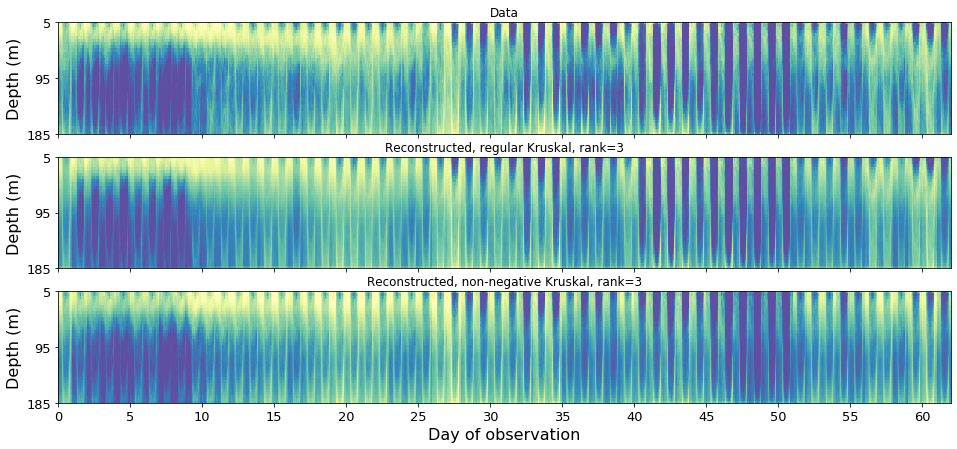

In [149]:
fig,ax = plt.subplots(3,1,figsize=(16,7),sharex=True)

# Data
plot_1_echogram_on_ax(ax[0], 
                      tl.unfold(tl.tensor(sonar_tensor[0,:,:].reshape((62,37,24))).squeeze(), mode=1)[::-1,:], 
                      24, 65, 5)
ax[0].set_title('Data')
ax[0].set_ylabel('Depth (m)',fontsize=16)

# Regular Kruskal
plot_1_echogram_on_ax(ax[1], 
                      tl.unfold(tl.tensor(full_tensor_3[0,:,:].reshape((62,37,24))).squeeze()+
                                sonar_tensor.min(), mode=1)[::-1,:],
                      24, 65, 5)
ax[1].set_title('Reconstructed, regular Kruskal, rank=%d'%kruskal_rank)
ax[1].set_ylabel('Depth (m)',fontsize=16)

# Non-negative Kruskal
plot_1_echogram_on_ax(ax[2], 
                      tl.unfold(tl.tensor(full_tensor_nonneg_3[0,:,:].reshape((62,37,24))+
                                          sonar_tensor.min()).squeeze(), mode=1)[::-1,:],
                      24, 65, 5)
ax[2].set_title('Reconstructed, non-negative Kruskal, rank=%d'%kruskal_rank)
ax[2].set_ylabel('Depth (m)',fontsize=16)

plt.xlabel('Day of observation',fontsize=16)

plt.show()

The patterns seem broadly similar, althought it is noticeable that the dark (low echo energy) patches are darker for regular Kruskal (e.g., around Day 35-45).

### Check individual components

To figure out which factor corresponds to which dimension, let's check the dimension of the factors:

In [150]:
[fac.shape for fac in factors_kruskal_nonneg_3.factors]

[(3, 3), (62, 3), (888, 3)]

Now we know that factor 0 corresponds with decomposition along `frequency`, factor 1 with `day of observation`, and factor 2 with `pixels in daily echogram`.

Let's now take a look at the component signatures in the frequency dimension.

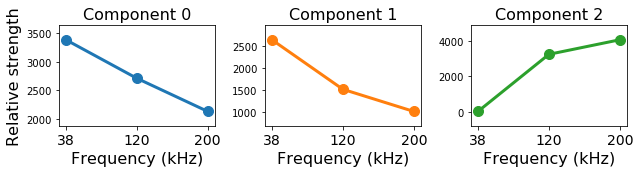

In [215]:
fig,ax = plt.subplots(1,3,figsize=(9,2.5))
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3.factors[0][:,i],'o-',linewidth=3,markersize=10,color='C%d'%i)
    ax[i].set_title('Component %d'% i, fontsize=16)
    ax[i].set_xticks(np.arange(3))
    ax[i].set_xticklabels([38,120,200], fontsize=14)
    ax[i].set_xlabel('Frequency (kHz)', fontsize=16)
#     ax[i].set_yticks([])
#     ax[i].set_yticklabels('', fontsize=14)
    if ax[i].is_first_col():
        ax[i].set_ylabel('Relative strength', fontsize=16)
    yrange = factors_kruskal_nonneg_3.factors[0][:,i].max()-factors_kruskal_nonneg_3.factors[0][:,i].min()
    ax[i].set_ylim(factors_kruskal_nonneg_3.factors[0][:,i].min()-yrange*0.2,
                   factors_kruskal_nonneg_3.factors[0][:,i].max()+yrange*0.2)
plt.tight_layout()
plt.show()

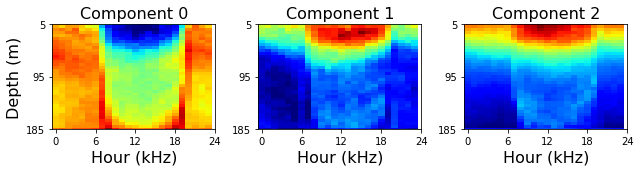

In [216]:
fig,ax = plt.subplots(1,3,figsize=(9,2.5))
for i in range(3):
    ax[i].imshow(factors_kruskal_nonneg_3.factors[2][:,i].reshape((37,24))[::-1,:],aspect='auto',cmap='jet')
    ax[i].set_title('Component %d'% i, fontsize=16)
    ax[i].set_xticks(np.arange(0,25,6))
    ax[i].set_yticks(range(0,37,18))
    ax[i].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
    ax[i].set_xlabel('Hour (kHz)', fontsize=16)
    if ax[i].is_first_col():
        ax[i].set_ylabel('Depth (m)', fontsize=16)
plt.tight_layout()
plt.show()

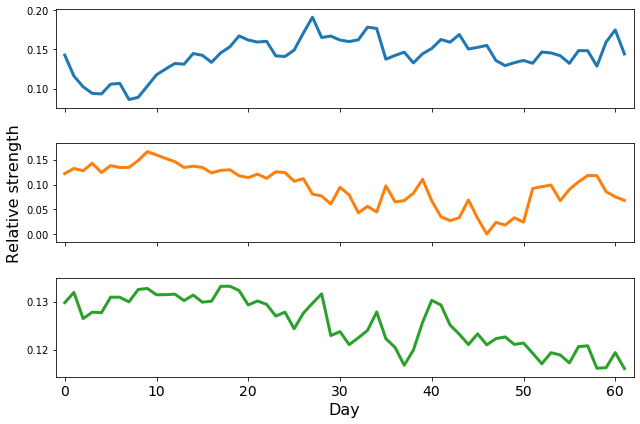

In [218]:
fig,ax = plt.subplots(3,1,figsize=(9,6),sharex=True)
fig.subplots_adjust(hspace=0.2)
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3.factors[1][:,i],linewidth=3,markersize=10,color='C%d'%i)
    ax[i].set_xticks(np.arange(0,62,10))
    ax[i].set_xticklabels(np.arange(0,62,10), fontsize=14)
    if i==1:
        ax[i].set_ylabel('Relative strength', fontsize=16)
    if ax[i].is_last_row():
        ax[i].set_xlabel('Day',fontsize=16)
    yrange = factors_kruskal_nonneg_3.factors[1][:,i].max()-factors_kruskal_nonneg_3.factors[1][:,i].min()
    ax[i].set_ylim(factors_kruskal_nonneg_3.factors[1][:,i].min()-yrange*0.1,
                   factors_kruskal_nonneg_3.factors[1][:,i].max()+yrange*0.1)
    ax[i].set_xlim(-1,62)
plt.tight_layout()
plt.show()

## Combine pairs of factors (non-negative parafac)

In [163]:
import itertools

In [164]:
# Khatri-kao product to combine the factors
kr_nn_patterns = []
kr_nn_combs = []
for x,y in itertools.combinations(range(3),2):
    kr_nn_patterns.append((x,y))
    kr_nn_combs.append(khatri_rao((factors_kruskal_nonneg_3.factors[x],factors_kruskal_nonneg_3.factors[y])))

In [165]:
sonar_tensor.shape

(3, 62, 888)

In [166]:
kr_nn_patterns

[(0, 1), (0, 2), (1, 2)]

In [167]:
[x.shape for x in kr_nn_combs]

[(186, 3), (2664, 3), (55056, 3)]

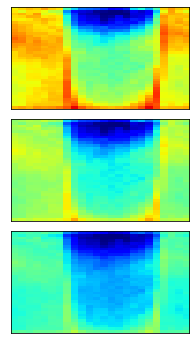

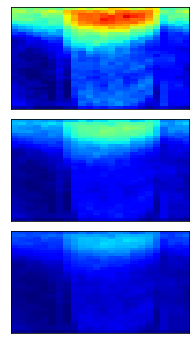

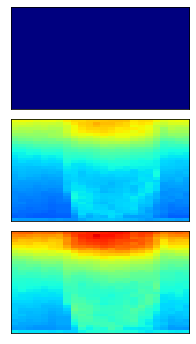

In [168]:
for fac in range(3):
    fig,ax = plt.subplots(3,1,figsize=(3.2,6),sharex=True)
    plt.subplots_adjust(hspace=0.1)
    tmp = tl.unfold(tl.tensor(kr_nn_combs[1][:,fac].reshape(3,37,24)[:,::-1,:]),mode=2).T
    zmax = tmp.max()
    zmin = tmp.min()
    for freq in range(3):
        ax[freq].imshow(tmp[freq*37+np.arange(0,37,1),:],aspect='auto',
                        vmax=zmax*1.1, vmin=zmin, cmap='jet')
        ax[freq].set_xticks([])
        ax[freq].set_yticks([])
#         ax[freq].set_xticks(np.arange(0,25,6))
#         ax[freq].set_xticklabels(np.arange(0,25,6), fontsize=14)
#         ax[freq].set_yticks(np.arange(0,37,18))
#         ax[freq].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size, fontsize=14)
#         if freq==1:
#             ax[freq].set_ylabel('Depth (m)', fontsize=16)
#         if freq==2:
#             ax[freq].set_xlabel('Hour', fontsize=16)
#         ax[freq].set_xlim(0,24)
#     plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor',
#                              'combine_dim_freq_dailyimg_%d.png'%fac),dpi=150)
    plt.show()

## Reconstructing data at 120 kHz

### Raw MVBS at 120 kHz

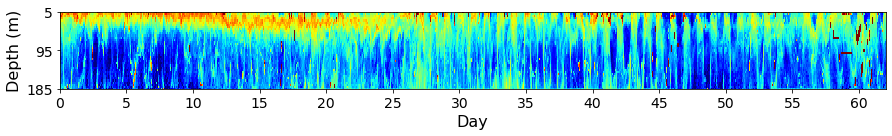

In [170]:
f = 1
fig = plt.figure(figsize=(12.5,2))
plt.imshow(MVBS_raw[f,37:0:-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*144,144*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Raw data, 120 kHz', fontsize=16)
plt.tight_layout()
# plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_original_MVBS_120kHz.png'),dpi=150)

### PCP-cleaned MVBS at 120 kHz

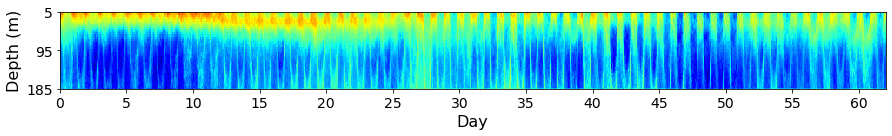

In [171]:
f = 1
fig = plt.figure(figsize=(12.5,2))
plt.imshow(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1)[::-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*144,144*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Data, 120 kHz', fontsize=16)
plt.tight_layout()
# plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_PCPcleaned_MVBS_120kHz.png'),dpi=150)

### Reconstruction from each component

In [172]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [173]:
kr_nn_cube_all = khatri_rao((factors_kruskal_nonneg_3.factors[0],
                             factors_kruskal_nonneg_3.factors[1],
                             factors_kruskal_nonneg_3.factors[2]))

In [174]:
kr_nn_cube_all.shape

(165168, 3)

In [175]:
3*62*37*24

165168

In [176]:
kr_nn_cube_all_fac = [kr_nn_cube_all[:,comp].reshape(L_sep_reduce.shape) for comp in range(3)]

In [177]:
kr_nn_cube_all_fac[0].shape

(3, 62, 37, 24)

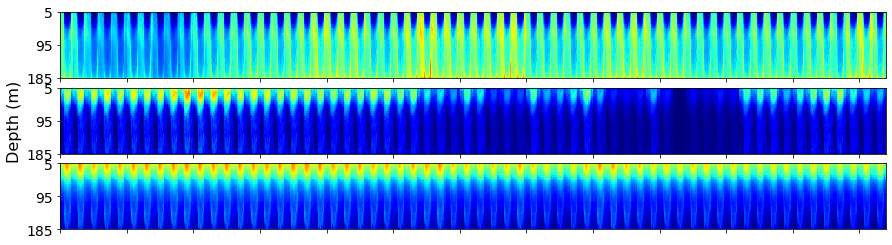

In [178]:
# fig,ax = plt.subplots(3,1,figsize=(13.5,5),sharex=True)
fig,ax = plt.subplots(3,1,figsize=(14.8,4),sharex=True)
plt.subplots_adjust(hspace=0.15)
for fac in range(3):
    zmax = kr_nn_cube_all_fac[fac][1,:,:,:].max()
    ax[fac].imshow(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][1,:,:,:].squeeze()[:,::-1,:]),mode=1),
                   aspect='auto',cmap='jet',vmax=zmax*1.2)
    ax[fac].set_xticks(np.arange(0,24*62,24*5))
#     ax[fac].set_xticklabels(np.arange(0,62,5),fontsize=14)
#     ax[fac].set_xticks([])
    ax[fac].set_xticklabels('')
    ax[fac].set_yticks(np.arange(0,37,18))
    ax[fac].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size,fontsize=14) 
    if fac==1:
        ax[fac].set_ylabel('Depth (m)', fontsize=16)
#     if fac==2:
#         ax[fac].set_xlabel('Day', fontsize=16)
#     ax[fac].set_title('Component %d, 120 kHz' % fac, fontsize=16)
# plt.tight_layout()
# plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_components_120kHz.png'),dpi=150)

### Summation using components at 120 kHz

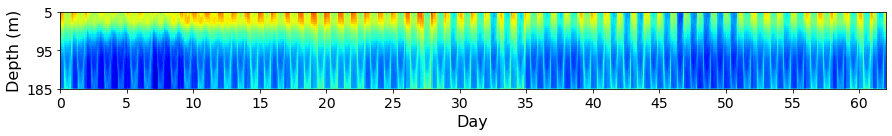

In [180]:
f = 1
fig = plt.figure(figsize=(12.5,2))
plt.imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[f,:,:].reshape((62,37,24))+sonar_tensor.min()).squeeze(), mode=1)[::-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*24,24*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Reconstruction, 120 kHz', fontsize=16)
plt.tight_layout()
# plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_reconstruction_120kHz.png'),dpi=150)

## Reconstructing data at 38 kHz

### Raw MVBS at 38 kHz

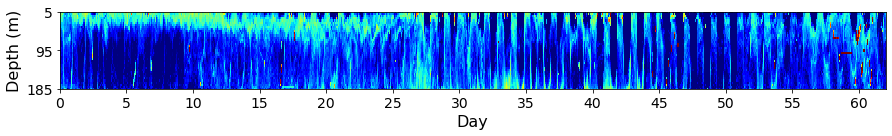

In [182]:
f = 0
fig = plt.figure(figsize=(12.5,2))
plt.imshow(MVBS_raw[f,37:0:-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*144,144*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Raw data, 120 kHz', fontsize=16)
plt.tight_layout()
# plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_original_MVBS_38kHz.png'),dpi=150)

### PCP-cleaned MVBS at 38 kHz

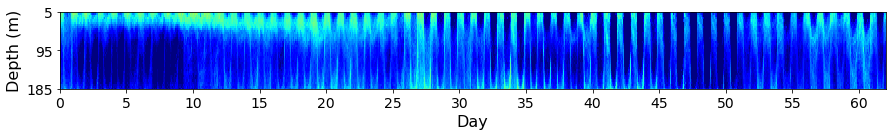

In [183]:
f = 0
fig = plt.figure(figsize=(12.5,2))
plt.imshow(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1)[::-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*144,144*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Data, 120 kHz', fontsize=16)
plt.tight_layout()
# plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_PCPcleaned_MVBS_38kHz.png'),dpi=150)

### Reconstruction from each component

In [184]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [187]:
kr_nn_cube_all = khatri_rao((factors_kruskal_nonneg_3.factors[0],
                             factors_kruskal_nonneg_3.factors[1],
                             factors_kruskal_nonneg_3.factors[2]))

In [188]:
kr_nn_cube_all.shape

(165168, 3)

In [189]:
3*62*37*24

165168

In [190]:
kr_nn_cube_all_fac = [kr_nn_cube_all[:,comp].reshape(L_sep_reduce.shape) for comp in range(3)]

In [191]:
kr_nn_cube_all_fac[0].shape

(3, 62, 37, 24)

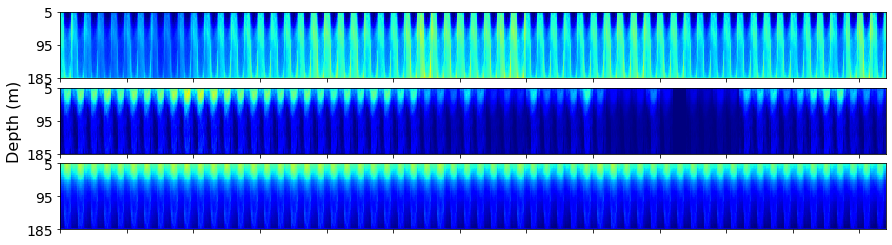

In [197]:
# fig,ax = plt.subplots(3,1,figsize=(13.5,5),sharex=True)
fig,ax = plt.subplots(3,1,figsize=(14.8,4),sharex=True)
plt.subplots_adjust(hspace=0.15)
for fac in range(3):
    zmax = kr_nn_cube_all_fac[fac][0,:,:,:].max()
    ax[fac].imshow(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][0,:,:,:].squeeze()[:,::-1,:]),mode=1),
                   aspect='auto',cmap='jet',vmax=zmax*1.5)
    ax[fac].set_xticks(np.arange(0,24*62,24*5))
#     ax[fac].set_xticklabels(np.arange(0,62,5),fontsize=14)
#     ax[fac].set_xticks([])
    ax[fac].set_xticklabels('')
    ax[fac].set_yticks(np.arange(0,37,18))
    ax[fac].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size,fontsize=14) 
    if fac==1:
        ax[fac].set_ylabel('Depth (m)', fontsize=16)
#     if fac==2:
#         ax[fac].set_xlabel('Day', fontsize=16)
#     ax[fac].set_title('Component %d, 120 kHz' % fac, fontsize=16)
# plt.tight_layout()
# plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_components_38kHz.png'),dpi=150)

### Summation using components at 120 kHz

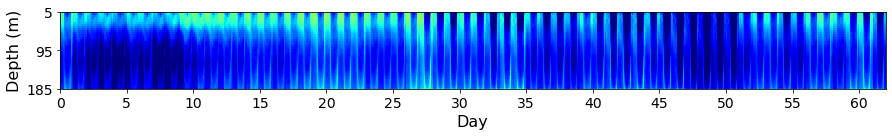

In [199]:
f = 0
fig = plt.figure(figsize=(12.5,2))
plt.imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[f,:,:].reshape((62,37,24))+sonar_tensor.min()).squeeze(), mode=1)[::-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*24,24*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Reconstruction, 120 kHz', fontsize=16)
plt.tight_layout()
# plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_reconstruction_38kHz.png'),dpi=150)

## Check variation over days

In [474]:
from scipy.spatial.distance import pdist, squareform

In [475]:
D = pdist(k_norm, 'euclidean')

In [476]:
D_square = squareform(D)

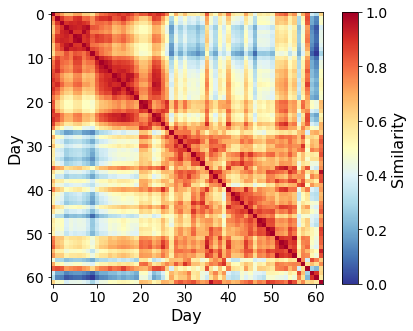

In [510]:
fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111)
plt.imshow(1-D_square/D_square.max(),cmap='RdYlBu_r')
plt.xticks(np.arange(0,62,10),fontsize=14)
plt.yticks(np.arange(0,62,10),fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Day',fontsize=16)
# cbar = plt.colorbar()
cbaxes = fig.add_axes([0.8, 0.125, 0.03, 0.755]) 
cbar = plt.colorbar(cax = cbaxes)  
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_ylabel('Similarity', rotation=90, fontsize=16)
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','similarity.png'),dpi=150)

## Clustering to check the similarity grouping

In [511]:
from scipy.cluster import hierarchy

In [512]:
Z = hierarchy.linkage(k_norm, 'ward')
Z_optimal = hierarchy.optimal_leaf_ordering(Z,k_norm)

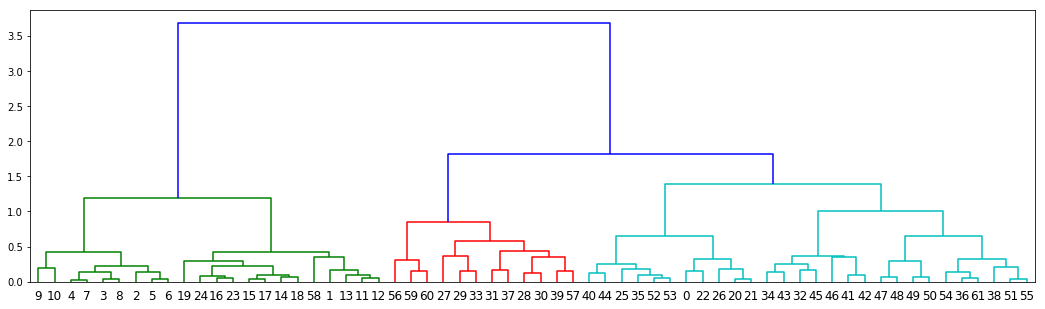

In [513]:
fig = plt.figure(figsize=(18, 5))
dn = hierarchy.dendrogram(Z,
                          leaf_rotation=0,
                          leaf_font_size=12,
                          color_threshold=1.5)
plt.show()

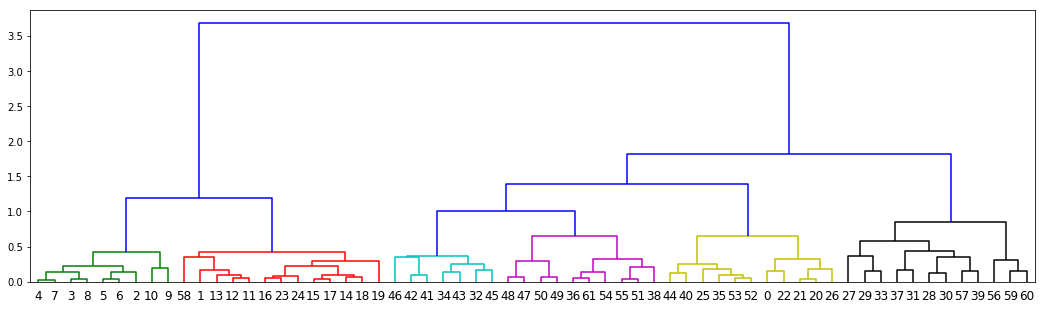

In [514]:
fig = plt.figure(figsize=(18, 5))
dn = hierarchy.dendrogram(Z_optimal,
                          leaf_rotation=0,
                          leaf_font_size=12,
                          color_threshold=1)
plt.show()

In [515]:
leaf_idx = hierarchy.leaves_list(Z_optimal)
leaf_idx

array([ 4,  7,  3,  8,  5,  6,  2, 10,  9, 58,  1, 13, 12, 11, 16, 23, 24,
       15, 17, 14, 18, 19, 46, 42, 41, 34, 43, 32, 45, 48, 47, 50, 49, 36,
       61, 54, 55, 51, 38, 44, 40, 25, 35, 53, 52,  0, 22, 21, 20, 26, 27,
       29, 33, 37, 31, 28, 30, 57, 39, 56, 59, 60], dtype=int32)

In [516]:
max_d = 1
clusters = hierarchy.fcluster(Z_optimal, max_d, criterion='distance')

cc = []
c_start = 0
c_end = 0
for c in np.arange(clusters.max())+1:
    c_idx = np.argwhere(clusters==c)
    print((c-1,c_start, c_start+len(c_idx)-1, np.array(c_idx).T))
    c_start = c_start+len(c_idx)
    cc.append(c_idx)

(0, 0, 8, array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10]]))
(1, 9, 21, array([[ 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 58]]))
(2, 22, 28, array([[32, 34, 41, 42, 43, 45, 46]]))
(3, 29, 38, array([[36, 38, 47, 48, 49, 50, 51, 54, 55, 61]]))
(4, 39, 49, array([[ 0, 20, 21, 22, 25, 26, 35, 40, 44, 52, 53]]))
(5, 50, 61, array([[27, 28, 29, 30, 31, 33, 37, 39, 56, 57, 59, 60]]))


In [517]:
leaf_idx_new = [cc[0],cc[1],cc[4],cc[3][::-1],cc[2],cc[5]]
leaf_idx_new = np.vstack(leaf_idx_new).squeeze()

In [518]:
D = pdist(k_norm, 'euclidean')
Dc = pdist(k_norm[leaf_idx], 'euclidean')
Dc_new = pdist(k_norm[leaf_idx_new], 'euclidean')

D_square = squareform(D)
Dc_square = squareform(Dc)
Dc_new_square = squareform(Dc_new)

Below plot the similarity matrix (1-normalized distance):

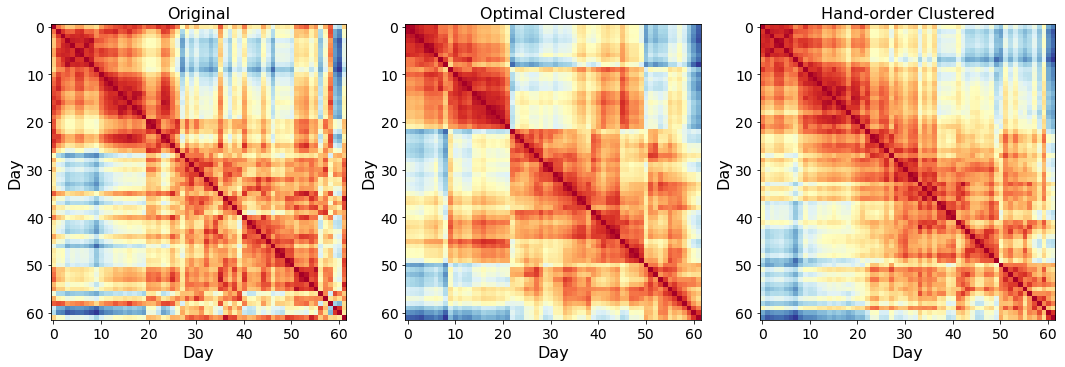

In [529]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
for panel in range(3):
    if panel==0:
        ax[panel].imshow(1-D_square/D_square.max(),cmap='RdYlBu_r')
        ax[panel].set_title('Original',fontsize=16)
    elif panel==1:
        ax[panel].imshow(1-Dc_square/Dc_square.max(),cmap='RdYlBu_r')
        ax[panel].set_title('Optimal Clustered',fontsize=16)        
    else:
        ax[panel].imshow(1-Dc_new_square/Dc_new_square.max(),cmap='RdYlBu_r')
        ax[panel].set_title('Hand-order Clustered',fontsize=16)        
    ax[panel].set_xlabel('Day',fontsize=16)
    ax[panel].set_ylabel('Day',fontsize=16)
    plt.setp(ax[panel].get_xticklabels(),fontsize=14)
    plt.setp(ax[panel].get_yticklabels(),fontsize=14)
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','similarity_clustered.png'),dpi=150)
plt.show()

Check how the clustered days relate to the original day sequence:

In [523]:
idx_link = np.vstack((np.arange(62),leaf_idx_new))
idx_link

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10,  1, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 23, 24, 58,  0, 20, 21, 22, 25, 26, 35, 40, 44, 52,
        53, 61, 55, 54, 51, 50, 49, 48, 47, 38, 36, 32, 34, 41, 42, 43,
        45, 46, 27, 28, 29, 30, 31, 33, 37, 39, 56, 57, 59, 60]])

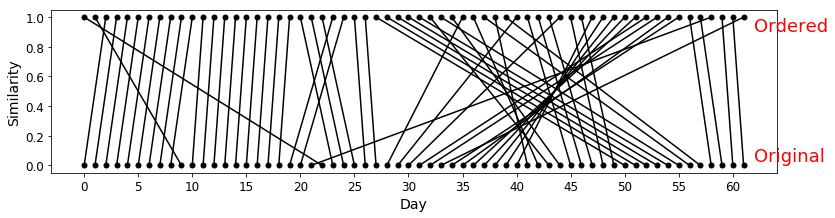

In [528]:
plt.figure(figsize=(13,3))
plt.plot(idx_link,[0,1],'k.-',markersize=10)
plt.xticks(np.arange(0,62,5),fontsize=12)
plt.xlabel('Day',fontsize=14)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.ylabel('Similarity',fontsize=14)
plt.text(62,0,'Original',{'fontsize':18,'va':'bottom','color':'r'})
plt.text(62,1,'Ordered',{'fontsize':18,'va':'top','color':'r'})
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','similarity_clustered_link.png'),dpi=150)
plt.show()